# VolGAN Hedging — Optimized for OptionMetrics Data

This notebook implements VolGAN-based hedging for SPX straddles using OptionMetrics data,
with data-driven surface generation and hedging optimization.

In [ ]:
# === CONFIGURATION: All Settings in One Place ===

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from scipy.stats import norm, skew as scipy_skew
from scipy.interpolate import griddata, interp1d
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
import seaborn as sns

# ===== CRITICAL SETTINGS =====
# Training/Test Split Configuration
TRAIN_END = pd.Timestamp('2020-12-31')          # Training data up to this date
BACKTEST_START = pd.Timestamp('2021-01-01')     # Backtest starts after training
BACKTEST_END = pd.Timestamp('2023-08-31')       # End of backtest period

# VolGAN Architecture
NOISE_DIM = 20                                   # Random noise dimension
HIDDEN_DIM = 256                                 # Hidden layer dimension (✓ OPTIMAL)
BATCH_SIZE = 64                                  # Batch size for training

# VolGAN Training Hyperparameters
N_EPOCHS_GRADIENT_MATCHING = 25                  # Gradient matching epochs (exploratory)
N_EPOCHS_MAIN_TRAINING = 2000                    # Main training epochs (✓ OPTIMAL - based on diagnostics)
LR_GENERATOR = 0.0001                            # Generator learning rate
LR_DISCRIMINATOR = 0.00005                       # Discriminator learning rate
ALPHA = 0.35                                     # Moneyness smoothness penalty (✓ EMPIRICALLY VALIDATED)
BETA = 0.45                                      # Temporal smoothness penalty (✓ EMPIRICALLY VALIDATED)

# IV Surface Grid
M_GRID = np.linspace(0.6, 1.4, 10)              # Moneyness grid (10 points)
DTE_GRID = [7, 14, 30, 60, 91, 122, 152, 182]   # Days to expiration (8 points)

# Hedging Configuration
TRADING_DAYS_PER_MONTH = 21                      # Window size for backtest
N_SCENARIOS_HEDGE = 1000                         # Number of VolGAN scenarios per hedge
M0_LIST = [0.75, 0.8, 0.9, 1.1, 1.2, 1.25]       # Moneyness values to test

# Data Files
OPTIONS_PARQUET = "../data/options_dataset.parquet"
OM_UNDERLYING_CSV = "../data/OMunderlying.csv"

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
print("\n" + "="*80)
print("CONFIGURATION SUMMARY")
print("="*80)
print(f"Train period: up to {TRAIN_END.date()}")
print(f"Backtest period: {BACKTEST_START.date()} to {BACKTEST_END.date()}")
print(f"Hidden dim: {HIDDEN_DIM} (✓ optimal for 80-dim IV surfaces)")
print(f"Main training epochs: {N_EPOCHS_MAIN_TRAINING} (✓ based on diagnostic convergence)")
print(f"Alpha (moneyness): {ALPHA} (✓ empirically validated)")
print(f"Beta (temporal): {BETA} (✓ empirically validated)")
print("="*80 + "\n")

Using device: cpu

CONFIGURATION SUMMARY
Train period: up to 2020-12-31
Backtest period: 2021-01-01 to 2023-12-31
Hidden dim: 256 (✓ optimal for 80-dim IV surfaces)
Main training epochs: 2000 (✓ based on diagnostic convergence)
Alpha (moneyness): 0.35 (✓ empirically validated)
Beta (temporal): 0.45 (✓ empirically validated)



In [2]:
# === SECTION 1: Data Loading Functions ===

def load_om_data_for_volgan(options_path, underlying_path):
    """Load and prepare OptionMetrics data for VolGAN."""
    # Load options
    df_opt = pd.read_parquet(options_path)
    df_opt = df_opt[df_opt['ticker'] == 'SPX'].copy()
    df_opt['date'] = pd.to_datetime(df_opt['date'])
    df_opt['exdate'] = pd.to_datetime(df_opt['exdate'])
    
    # Strike scaling
    if df_opt['strike_price'].median() > 1e4:
        df_opt['strike_price'] = df_opt['strike_price'] / 1000.0
    
    df_opt['dte'] = (df_opt['exdate'] - df_opt['date']).dt.days
    df_opt['mid'] = (df_opt['best_bid'] + df_opt['best_offer']) / 2.0
    
    # Load spot
    df_spot = pd.read_csv(underlying_path)
    df_spot['date'] = pd.to_datetime(df_spot['date'])
    df_spot = df_spot[df_spot['ticker'] == 'SPX'][['date', 'close']].rename(columns={'close': 'spot'})
    df_spot = df_spot.drop_duplicates('date').sort_values('date')
    
    # Merge
    df_opt = df_opt.merge(df_spot, on='date', how='inner')
    df_opt['moneyness'] = df_opt['strike_price'] / df_opt['spot']
    
    return df_opt, df_spot

In [3]:
# === SECTION 2: Load and Quality-Filter Data ===

df_options, df_underlying = load_om_data_for_volgan(OPTIONS_PARQUET, OM_UNDERLYING_CSV)
print(f"Raw data loaded: {len(df_options)} option rows")

# Quality Screening
df = df_options.copy()
df['moneyness'] = df['strike_price'] / df['spot']

# Filter to ~1-month maturity (15-35 calendar days)
df_1m = df[(df['dte'] >= 15) & (df['dte'] <= 35)].copy()
print(f"After DTE filter (15-35 days): {len(df_1m)} rows")

# Quality filters
df_1m = df_1m.replace([np.inf, -np.inf], np.nan)
df_1m = df_1m.dropna(subset=['mid', 'delta', 'vega', 'best_bid', 'best_offer'])
df_1m = df_1m[df_1m['best_offer'] >= df_1m['best_bid']].copy()

# Compute spread metrics
df_1m['spread'] = (df_1m['best_offer'] - df_1m['best_bid']).clip(lower=0)
df_1m['rel_spread'] = (df_1m['spread'] / df_1m['mid']).replace([np.inf, -np.inf], np.nan)

# Liquidity screens
liq_mask = (
    (df_1m['mid'] > 0.05) &
    (df_1m['rel_spread'] <= 0.35) &
    df_1m['delta'].between(-1.1, 1.1) &
    (df_1m['vega'] > 0)
)
df_1m = df_1m[liq_mask].copy()

print(f"After quality filters: {len(df_1m)} rows")
print(f"Date range: {df_1m['date'].min().date()} → {df_1m['date'].max().date()}")
print(f"Coverage: {len(df_1m['date'].unique())} unique trading days\n")

# Keep relevant columns
cols_keep = ['date', 'exdate', 'cp_flag', 'strike_price', 'spot', 'moneyness', 
             'dte', 'mid', 'best_bid', 'best_offer', 'volume', 'open_interest', 
             'delta', 'vega', 'impl_volatility', 'spread', 'rel_spread']
cols_available = [c for c in cols_keep if c in df_1m.columns]
df_1m_filtered = df_1m[cols_available].sort_values(['date', 'dte', 'strike_price']).reset_index(drop=True)

print(f"Final filtered dataset: {len(df_1m_filtered)} rows\n")

Raw data loaded: 36251366 option rows
After DTE filter (15-35 days): 7465938 rows
After quality filters: 5689084 rows
Date range: 2000-01-03 → 2023-08-31
Coverage: 5099 unique trading days

Final filtered dataset: 5689084 rows



In [4]:
# === SECTION 3: Build IV Surface Grid ===

def build_iv_surface_grid_robust(df_opt, m_grid, dte_grid):
    """Build IV surface with robust handling of days with insufficient data."""
    dates = sorted(df_opt['date'].unique())
    surfaces = []
    valid_dates = []
    
    for d in tqdm(dates, desc="Building IV surfaces"):
        day_df = df_opt[df_opt['date'] == d]
        points = day_df[['moneyness', 'dte', 'impl_volatility']].dropna()
        
        if len(points) < 10:
            continue
        
        unique_dte = points['dte'].nunique()
        unique_moneyness = points['moneyness'].nunique()
        
        if unique_dte < 2 or unique_moneyness < 3:
            continue
        
        dte_min, dte_max = points['dte'].min(), points['dte'].max()
        if dte_max - dte_min < 10:
            continue
        
        grid_m, grid_dte = np.meshgrid(m_grid, dte_grid)
        
        try:
            iv_surface = griddata(
                points[['moneyness', 'dte']].values,
                points['impl_volatility'].values,
                (grid_m, grid_dte),
                method='linear',
                fill_value=np.nan
            )
            
            if np.isnan(iv_surface).any():
                iv_surface_filled = griddata(
                    points[['moneyness', 'dte']].values,
                    points['impl_volatility'].values,
                    (grid_m, grid_dte),
                    method='nearest'
                )
                iv_surface = np.where(np.isnan(iv_surface), iv_surface_filled, iv_surface)
            
            if np.isnan(iv_surface).sum() > 0.5 * iv_surface.size:
                continue
            
            surfaces.append(iv_surface.T.flatten())
            valid_dates.append(d)
            
        except Exception as e:
            continue
    
    if len(surfaces) == 0:
        raise ValueError("No valid surfaces could be constructed!")
    
    surfaces_array = np.array(surfaces)
    tau_grid_years = np.array(dte_grid) / 365.0
    
    print(f"Surface construction: {len(valid_dates)}/{len(dates)} days ({100*len(valid_dates)/len(dates):.1f}%)")
    
    return surfaces_array, valid_dates, m_grid, tau_grid_years

surfaces_transform, dates_volgan, m, tau = build_iv_surface_grid_robust(
    df_1m_filtered, M_GRID, DTE_GRID
)
print(f"Surface grid shape: {surfaces_transform.shape}\n")

Building IV surfaces: 100%|██████████| 5099/5099 [00:48<00:00, 104.15it/s]

Surface construction: 2934/5099 days (57.5%)
Surface grid shape: (2934, 80)



In [5]:
# === SECTION 4: Prepare VolGAN Training Data ===

def prepare_volgan_data_om(surfaces, dates_list, df_spot):
    """Prepare condition and target arrays for VolGAN."""
    dates_pd = pd.to_datetime(dates_list)
    spot_df = df_spot[df_spot['date'].isin(dates_pd)].sort_values('date')
    prices = spot_df['spot'].values
    
    # Log returns
    prices_prev = np.zeros(len(prices))
    prices_prev[1:] = prices[:-1]
    prices_prev[0] = prices[0]
    log_rtn = np.log(prices) - np.log(prices_prev)
    
    # Realized volatility (21-day rolling)
    realised_vol_tm1 = np.zeros(len(log_rtn) - 22)
    for i in range(len(realised_vol_tm1)):
        realised_vol_tm1[i] = np.sqrt(252 / 21) * np.sqrt(np.sum(log_rtn[i:(i+21)]**2))
    
    # Align dates and compute features
    dates_t = dates_pd[22:]
    log_rtn_t = log_rtn[22:]
    log_rtn_tm1 = np.sqrt(252) * log_rtn[21:-1]
    log_rtn_tm2 = np.sqrt(252) * log_rtn[20:-2]
    
    # Log IV surfaces
    log_iv_t = np.log(surfaces[22:])
    log_iv_tm1 = np.log(surfaces[21:-1])
    log_iv_inc_t = log_iv_t - log_iv_tm1
    
    # Condition: [r_{t-1}, r_{t-2}, RV_{t-1}, log_iv_{t-1}]
    condition = np.concatenate((
        np.expand_dims(log_rtn_tm1, axis=1),
        np.expand_dims(log_rtn_tm2, axis=1),
        np.expand_dims(realised_vol_tm1, axis=1),
        log_iv_tm1
    ), axis=1)
    
    # Target: [r_t, log_iv_inc_t]
    log_rtn_t_ann = np.sqrt(252) * log_rtn_t
    true = np.concatenate((
        np.expand_dims(log_rtn_t_ann, axis=1),
        log_iv_inc_t
    ), axis=1)
    
    return true, condition, dates_t

true, condition, dates_volgan_aligned = prepare_volgan_data_om(
    surfaces_transform, dates_volgan, df_underlying
)
print(f"VolGAN data shapes: true={true.shape}, condition={condition.shape}\n")

VolGAN data shapes: true=(2912, 81), condition=(2912, 83)



In [6]:
# === SECTION 5: SINGLE Train/Test Split (NO DUPLICATES) ===

dates_pd = pd.to_datetime(dates_volgan_aligned)

# ===== TRAIN DATA: For VolGAN model training =====
train_mask = dates_pd <= TRAIN_END
true_train = torch.tensor(true[train_mask], dtype=torch.float, device=device)
condition_train = torch.tensor(condition[train_mask], dtype=torch.float, device=device)

# ===== TEST DATA: For VolGAN model evaluation (used in backtest) =====
test_mask = dates_pd > TRAIN_END
true_test = torch.tensor(true[test_mask], dtype=torch.float, device=device)
condition_test_all = torch.tensor(condition[test_mask], dtype=torch.float, device=device)
dates_test_all = dates_pd[test_mask]

print(f"Train/Test Split:")
print(f"  Train: {true_train.shape[0]} samples (up to {TRAIN_END.date()})")
print(f"  Test: {true_test.shape[0]} samples (after {TRAIN_END.date()})")
print(f"  Condition dim: {condition_train.shape[1]}")
print(f"  Target dim: {true_train.shape[1]}\n")

Train/Test Split:
  Train: 2242 samples (up to 2020-12-31)
  Test: 670 samples (after 2020-12-31)
  Condition dim: 83
  Target dim: 81



In [7]:
# === SECTION 6: VolGAN Model Classes ===

class Generator(nn.Module):
    def __init__(self, noise_dim, cond_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.linear1 = nn.Linear(noise_dim + cond_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.linear3 = nn.Linear(hidden_dim * 2, output_dim)
        self.activation = nn.Softplus()
    
    def forward(self, noise, condition):
        out = torch.cat([noise, condition], dim=-1).to(torch.float)
        out = self.activation(self.linear1(out))
        out = self.activation(self.linear2(out))
        out = self.linear3(out)
        return out

class Discriminator(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.linear1 = nn.Linear(in_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 1)
        self.activation = nn.Softplus()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.activation(self.linear1(x))
        out = self.sigmoid(self.linear2(out))
        return out

In [8]:
# === SECTION 7: Black-Scholes Pricing ===

def BS_call(S, tau, K, sigma, r=0):
    d1 = (np.log(S/K) + tau*(r + 0.5*sigma**2)) / (sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)
    return S*norm.cdf(d1) - K*norm.cdf(d2)*np.exp(-r*tau)

def BS_put(S, tau, K, sigma, r=0):
    d1 = (np.log(S/K) + tau*(r + 0.5*sigma**2)) / (sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)
    return K*norm.cdf(-d2)*np.exp(-r*tau) - S*norm.cdf(-d1)

In [9]:
# === SECTION 8: VolGAN Hedging Function ===

def hedge_with_volgan(gen, condition_t, spot_t, K_straddle, hedge_options, 
                      m_grid, tau_grid, n_scenarios=N_SCENARIOS_HEDGE, device='cpu'):
    """Generate VolGAN scenarios and compute LASSO hedge ratios."""
    gen.eval()
    with torch.no_grad():
        noise = torch.randn((n_scenarios, gen.noise_dim), device=device)
        condition_batch = condition_t.unsqueeze(0).repeat(n_scenarios, 1)
        fake = gen(noise, condition_batch)
        spot_ret_scenarios = fake[:, 0].cpu().numpy() / np.sqrt(252)
        log_iv_inc_scenarios = fake[:, 1:].cpu().numpy()
    
    spot_t1_scenarios = spot_t * np.exp(spot_ret_scenarios)
    iv_current = np.exp(condition_t[3:].cpu().numpy())
    
    V_scenarios = []
    for i in range(n_scenarios):
        S_t1 = spot_t1_scenarios[i]
        iv_t1 = iv_current * np.exp(log_iv_inc_scenarios[i])
        iv_surface = iv_t1.reshape(len(m_grid), len(tau_grid))
        
        m_straddle = K_straddle / S_t1
        tau_straddle = 21 / 365
        
        iv_at_tau = interp1d(tau_grid, iv_surface, axis=1, 
                             bounds_error=False, fill_value='extrapolate')(tau_straddle)
        iv_interp = np.clip(np.interp(m_straddle, m_grid, iv_at_tau), 0.01, 2.0)
        
        V_call = BS_call(S_t1, tau_straddle, K_straddle, iv_interp, r=0)
        V_put = BS_put(S_t1, tau_straddle, K_straddle, iv_interp, r=0)
        V_scenarios.append(V_call + V_put)
    
    V_scenarios = np.array(V_scenarios)
    
    # Hedge instruments
    H_scenarios = {'spot': spot_t1_scenarios}
    
    for opt in hedge_options:
        H_values = []
        for i in range(n_scenarios):
            S_t1 = spot_t1_scenarios[i]
            iv_t1 = iv_current * np.exp(log_iv_inc_scenarios[i])
            iv_surface = iv_t1.reshape(len(m_grid), len(tau_grid))
            
            m_opt = opt['K'] / S_t1
            tau_opt = 21 / 365
            
            iv_at_tau = interp1d(tau_grid, iv_surface, axis=1, 
                                 bounds_error=False, fill_value='extrapolate')(tau_opt)
            iv_opt = np.clip(np.interp(m_opt, m_grid, iv_at_tau), 0.01, 2.0)
            
            if opt['cp'] == 'C':
                H_val = BS_call(S_t1, tau_opt, opt['K'], iv_opt, r=0)
            else:
                H_val = BS_put(S_t1, tau_opt, opt['K'], iv_opt, r=0)
            H_values.append(H_val)
        
        H_scenarios[f"{opt['cp']}_{opt['K']}"] = np.array(H_values)
    
    # LASSO regression
    X = pd.DataFrame(H_scenarios)
    y = V_scenarios
    
    lasso = LassoCV(alphas=np.logspace(-4, 0, 20), cv=3, max_iter=5000)
    lasso.fit(X, y)
    
    hedge_ratios = {instr: coef for instr, coef in zip(X.columns, lasso.coef_)}
    return hedge_ratios

In [10]:
# === SECTION 9: Backtest Utility Functions ===

def get_window_dates(df_all, start_idx):
    dates = np.sort(df_all['date'].unique())
    if start_idx + TRADING_DAYS_PER_MONTH >= len(dates):
        return None
    return list(dates[start_idx:start_idx + TRADING_DAYS_PER_MONTH + 1])

def choose_strike_for_m0(spot0, m0, strikes):
    target = m0 * spot0
    return float(strikes[np.abs(strikes - target).argmin()])

def pick_one(day_df, strike, cp_flag):
    sub = day_df[(day_df['strike_price'] == strike) & (day_df['cp_flag'] == cp_flag)].copy()
    if sub.empty:
        return None
    sub = sub.dropna(subset=['mid', 'delta', 'vega'])
    sub = sub[sub['best_offer'] >= sub['best_bid']]
    if sub.empty:
        return None
    sub = sub.sort_values(by=['open_interest', 'volume'], ascending=[False, False])
    return sub.iloc[0]

def fetch_next_row(next_df, strike, cp_flag):
    nxt = next_df[(next_df['strike_price'] == strike) & (next_df['cp_flag'] == cp_flag)]
    if nxt.empty:
        return None
    nxt = nxt.dropna(subset=['mid'])
    nxt = nxt.sort_values(by=['open_interest', 'volume'], ascending=[False, False])
    return nxt.iloc[0]

In [11]:
# === SECTION 10: Single Window Runner ===

def run_volgan_window(df_all, gen, start_idx, m0, m_grid, tau_grid, 
                      condition_data, dates_data, device='cpu'):
    """Run one 21-day VolGAN hedging window."""
    days = get_window_dates(df_all, start_idx)
    if days is None:
        return None
    
    d0 = pd.Timestamp(days[0])
    day0 = df_all[df_all['date'] == d0]
    if day0.empty:
        return None
    
    spot0 = float(day0['spot'].iloc[0])
    strikes0 = np.sort(day0['strike_price'].unique())
    K_straddle = choose_strike_for_m0(spot0, m0, strikes0)
    
    hedge_options = [
        {'K': K_straddle, 'cp': 'C'},
        {'K': K_straddle, 'cp': 'P'},
        {'K': K_straddle * 0.9, 'cp': 'P'},
        {'K': K_straddle * 1.1, 'cp': 'C'},
    ]
    
    records = []
    V0, Pi_t = None, None
    phi_prev = {}
    
    for t in range(len(days) - 1):
        d, d_next = pd.Timestamp(days[t]), pd.Timestamp(days[t + 1])
        
        day = df_all[df_all['date'] == d]
        day_next = df_all[df_all['date'] == d_next]
        
        if day.empty or day_next.empty:
            return None
        
        row_C = pick_one(day, K_straddle, 'C')
        row_P = pick_one(day, K_straddle, 'P')
        if row_C is None or row_P is None:
            return None
        
        V_t = row_C['mid'] + row_P['mid']
        spot_t = row_C['spot']
        
        if V0 is None:
            V0 = V_t
            Pi_t = V0
        
        try:
            date_idx = np.where(dates_data == d)[0][0]
            condition_t = torch.tensor(condition_data[date_idx], dtype=torch.float, device=device)
        except (IndexError, ValueError):
            return None
        
        hedge_ratios = hedge_with_volgan(
            gen, condition_t, spot_t, K_straddle, hedge_options,
            m_grid, tau_grid, n_scenarios=N_SCENARIOS_HEDGE, device=device
        )
        
        row_C_next = fetch_next_row(day_next, K_straddle, 'C')
        row_P_next = fetch_next_row(day_next, K_straddle, 'P')
        if row_C_next is None or row_P_next is None:
            return None
        
        spot_t1 = row_C_next['spot']
        V_t1 = row_C_next['mid'] + row_P_next['mid']
        
        pnl_total = 0
        cost_total = 0
        
        phi_spot = hedge_ratios.get('spot', 0)
        pnl_total += phi_spot * (spot_t1 - spot_t)
        
        for opt in hedge_options:
            key = f"{opt['cp']}_{opt['K']}"
            phi_opt = hedge_ratios.get(key, 0)
            
            opt_t = pick_one(day, opt['K'], opt['cp'])
            opt_t1 = fetch_next_row(day_next, opt['K'], opt['cp'])
            
            if opt_t is not None and opt_t1 is not None:
                pnl_total += phi_opt * (opt_t1['mid'] - opt_t['mid'])
                phi_opt_prev = phi_prev.get(key, 0)
                cost_total += abs(phi_opt - phi_opt_prev) * (opt_t['best_offer'] - opt_t['best_bid']) / 2.0
        
        Pi_t1 = Pi_t + pnl_total - cost_total
        
        records.append({
            'date': d,
            'V_t': V_t,
            'Pi_t': Pi_t,
            'Pi_t1': Pi_t1,
            'pnl_hedged': pnl_total - cost_total,
            'pnl_unhedged': V_t1 - V_t
        })
        
        phi_prev = hedge_ratios.copy()
        Pi_t = Pi_t1
    
    # Final valuation
    last_day, final_day = pd.Timestamp(days[-2]), pd.Timestamp(days[-1])
    day_last = df_all[df_all['date'] == last_day]
    day_final = df_all[df_all['date'] == final_day]
    
    row_C_fin = fetch_next_row(day_final, K_straddle, 'C')
    row_P_fin = fetch_next_row(day_final, K_straddle, 'P')
    
    if row_C_fin is None or row_P_fin is None:
        return None
    
    V_T = row_C_fin['mid'] + row_P_fin['mid']
    Pi_T = records[-1]['Pi_t1']
    
    summary = {
        'start': days[0],
        'end': days[-1],
        'm0': m0,
        'V0': V0,
        'V_T': V_T,
        'Pi_T': Pi_T,
        'tracking_error': V_T - Pi_T,
        'pnl_unhedged': V_T - V0,
        'pnl_hedged': Pi_T - V0,
        'strategy': 'VolGAN'
    }
    
    return {'timeline': pd.DataFrame(records), 'summary': summary}

In [12]:
# === SECTION 11: Multi-Window Experiment ===

def run_volgan_experiment(df_all, gen, m0_list, condition_data, dates_data,
                          m_grid, tau_grid, max_windows=52, device='cpu'):
    """Run VolGAN across multiple windows."""
    dates = np.sort(df_all['date'].unique())
    start_indices = list(range(0, len(dates) - TRADING_DAYS_PER_MONTH - 1, TRADING_DAYS_PER_MONTH))
    start_indices = start_indices[:max_windows]
    
    results = []
    for m0 in m0_list:
        print(f"\n===== VolGAN: m0={m0} =====")
        for i, si in enumerate(start_indices, 1):
            print(f"Window {i}/{len(start_indices)}")
            out = run_volgan_window(
                df_all, gen, si, m0, m_grid, tau_grid,
                condition_data, dates_data, device
            )
            if out is not None:
                results.append(out['summary'])
    
    return pd.DataFrame(results)

In [13]:
# === SECTION 12: Initialize and Train VolGAN ===

cond_dim = condition_train.shape[1]
output_dim = true_train.shape[1]

gen = Generator(noise_dim=NOISE_DIM, cond_dim=cond_dim, hidden_dim=HIDDEN_DIM, output_dim=output_dim)
disc = Discriminator(in_dim=cond_dim + output_dim, hidden_dim=HIDDEN_DIM)

gen.to(device)
disc.to(device)

print(f"Generator parameters: {sum(p.numel() for p in gen.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in disc.parameters()):,}\n")

Generator parameters: 199,761
Discriminator parameters: 42,497



In [14]:
# === SECTION 13: Train VolGAN with Empirically-Validated Settings ===

def train_volgan(gen, disc, alpha, beta,
                condition_train, true_train, m_grid, tau_grid,
                n_epochs=N_EPOCHS_MAIN_TRAINING, batch_size=BATCH_SIZE, device='cpu'):
    """Main VolGAN training with optimal hyperparameters."""
    criterion = nn.BCELoss()
    gen_opt = torch.optim.Adam(gen.parameters(), lr=LR_GENERATOR, betas=(0.5, 0.999))
    disc_opt = torch.optim.Adam(disc.parameters(), lr=LR_DISCRIMINATOR, betas=(0.5, 0.999))
    
    n_train = condition_train.shape[0]
    n_batches = n_train // batch_size + 1
    
    lk, lt = len(m_grid), len(tau_grid)
    disc_losses = []
    gen_losses = []
    
    gen.train()
    disc.train()
    
    for epoch in tqdm(range(n_epochs), desc="Training VolGAN"):
        perm = torch.randperm(n_train)
        condition_train_perm = condition_train[perm]
        true_train_perm = true_train[perm]
        
        epoch_disc_loss = 0
        epoch_gen_loss = 0
        
        for i in range(n_batches):
            curr_batch_size = min(batch_size, n_train - i*batch_size)
            condition = condition_train_perm[i*batch_size:i*batch_size + curr_batch_size]
            real = true_train_perm[i*batch_size:i*batch_size + curr_batch_size]
            surface_past = condition[:, 3:]
            
            # Update Discriminator
            disc_opt.zero_grad()
            noise = torch.randn((curr_batch_size, NOISE_DIM), device=device, dtype=torch.float)
            fake = gen(noise, condition)
            
            real_and_cond = torch.cat((condition, real), dim=-1)
            fake_and_cond = torch.cat((condition, fake), dim=-1)
            
            disc_fake_pred = disc(fake_and_cond.detach())
            disc_real_pred = disc(real_and_cond)
            
            disc_loss = (criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred)) +
                        criterion(disc_real_pred, torch.ones_like(disc_real_pred))) / 2
            disc_loss.backward()
            disc_opt.step()
            
            epoch_disc_loss += disc_loss.item()
            
            # Update Generator
            gen_opt.zero_grad()
            noise = torch.randn((curr_batch_size, NOISE_DIM), device=device, dtype=torch.float)
            fake = gen(noise, condition)
            fake_and_cond = torch.cat((condition, fake), dim=-1)
            
            disc_fake_pred = disc(fake_and_cond)
            gen_bce_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
            
            # Smoothness penalties
            fake_surface = torch.exp(fake[:, 1:] + surface_past)
            fake_surface_grid = fake_surface.reshape(curr_batch_size, lk, lt)
            
            m_diffs = fake_surface_grid[:, 1:, :] - fake_surface_grid[:, :-1, :]
            m_penalty = torch.mean(m_diffs ** 2)
            
            t_diffs = fake_surface_grid[:, :, 1:] - fake_surface_grid[:, :, :-1]
            t_penalty = torch.mean(t_diffs ** 2)
            
            gen_loss = gen_bce_loss + alpha * m_penalty + beta * t_penalty
            gen_loss.backward()
            gen_opt.step()
            
            epoch_gen_loss += gen_loss.item()
        
        if (epoch + 1) % 100 == 0:
            avg_disc = epoch_disc_loss / n_batches
            avg_gen = epoch_gen_loss / n_batches
            print(f"Epoch {epoch+1}/{n_epochs} | D_loss: {avg_disc:.4f} | G_loss: {avg_gen:.4f}")
        
        disc_losses.append(epoch_disc_loss / n_batches)
        gen_losses.append(epoch_gen_loss / n_batches)
    
    return gen, disc, disc_losses, gen_losses

print("\n" + "="*80)
print("TRAINING VolGAN WITH OPTIMIZED SETTINGS")
print("="*80)
print(f"Alpha (moneyness): {ALPHA}")
print(f"Beta (temporal): {BETA}")
print(f"Epochs: {N_EPOCHS_MAIN_TRAINING}")
print(f"Batch size: {BATCH_SIZE}")
print("="*80 + "\n")

gen, disc, disc_losses, gen_losses = train_volgan(
    gen, disc, ALPHA, BETA,
    condition_train, true_train, m, tau,
    n_epochs=N_EPOCHS_MAIN_TRAINING, batch_size=BATCH_SIZE, device=device
)

# Save
torch.save(gen.state_dict(), 'volgan_trained_final.pt')
print("\n✓ Model saved: volgan_trained_final.pt")


TRAINING VolGAN WITH OPTIMIZED SETTINGS
Alpha (moneyness): 0.35
Beta (temporal): 0.45
Epochs: 2000
Batch size: 64



Training VolGAN:   5%|▌         | 101/2000 [00:11<03:34,  8.84it/s]

Epoch 100/2000 | D_loss: 0.6978 | G_loss: 0.6969


Training VolGAN:  10%|█         | 201/2000 [00:22<03:23,  8.84it/s]

Epoch 200/2000 | D_loss: 0.6943 | G_loss: 0.7015


Training VolGAN:  15%|█▌        | 301/2000 [00:34<03:12,  8.81it/s]

Epoch 300/2000 | D_loss: 0.6936 | G_loss: 0.6977


Training VolGAN:  20%|██        | 401/2000 [00:45<03:01,  8.82it/s]

Epoch 400/2000 | D_loss: 0.6935 | G_loss: 0.6955


Training VolGAN:  25%|██▌       | 501/2000 [00:56<02:51,  8.77it/s]

Epoch 500/2000 | D_loss: 0.6937 | G_loss: 0.7019


Training VolGAN:  30%|███       | 601/2000 [01:08<02:37,  8.86it/s]

Epoch 600/2000 | D_loss: 0.6932 | G_loss: 0.6987


Training VolGAN:  35%|███▌      | 701/2000 [01:19<02:28,  8.75it/s]

Epoch 700/2000 | D_loss: 0.6922 | G_loss: 0.7041


Training VolGAN:  40%|████      | 801/2000 [01:30<02:16,  8.81it/s]

Epoch 800/2000 | D_loss: 0.6932 | G_loss: 0.7003


Training VolGAN:  45%|████▌     | 901/2000 [01:42<02:05,  8.73it/s]

Epoch 900/2000 | D_loss: 0.6932 | G_loss: 0.6957


Training VolGAN:  50%|█████     | 1001/2000 [01:53<01:53,  8.82it/s]

Epoch 1000/2000 | D_loss: 0.6928 | G_loss: 0.6930


Training VolGAN:  55%|█████▌    | 1101/2000 [02:04<01:41,  8.84it/s]

Epoch 1100/2000 | D_loss: 0.6933 | G_loss: 0.6955


Training VolGAN:  60%|██████    | 1201/2000 [02:16<01:30,  8.81it/s]

Epoch 1200/2000 | D_loss: 0.6935 | G_loss: 0.6922


Training VolGAN:  65%|██████▌   | 1301/2000 [02:27<01:19,  8.80it/s]

Epoch 1300/2000 | D_loss: 0.6930 | G_loss: 0.6949


Training VolGAN:  70%|███████   | 1401/2000 [02:38<01:07,  8.86it/s]

Epoch 1400/2000 | D_loss: 0.6929 | G_loss: 0.6950


Training VolGAN:  75%|███████▌  | 1501/2000 [02:50<00:56,  8.83it/s]

Epoch 1500/2000 | D_loss: 0.6929 | G_loss: 0.6953


Training VolGAN:  80%|████████  | 1601/2000 [03:01<00:45,  8.81it/s]

Epoch 1600/2000 | D_loss: 0.6935 | G_loss: 0.6982


Training VolGAN:  85%|████████▌ | 1701/2000 [03:12<00:33,  8.83it/s]

Epoch 1700/2000 | D_loss: 0.6928 | G_loss: 0.6933


Training VolGAN:  90%|█████████ | 1801/2000 [03:24<00:22,  8.79it/s]

Epoch 1800/2000 | D_loss: 0.6929 | G_loss: 0.6939


Training VolGAN:  95%|█████████▌| 1901/2000 [03:35<00:11,  8.53it/s]

Epoch 1900/2000 | D_loss: 0.6930 | G_loss: 0.6947


Training VolGAN: 100%|██████████| 2000/2000 [03:46<00:00,  8.82it/s]

Epoch 2000/2000 | D_loss: 0.6929 | G_loss: 0.6937

✓ Model saved: volgan_trained_final.pt


In [15]:
# === SECTION 13B: SURFACE QUALITY EVALUATION (POST-TRAINING) ===

from scipy.stats import skew as scipy_skew

def evaluate_surface(surface, m_grid, tau_grid, real_surface=None):
    """Comprehensive surface quality diagnostic."""
    lk, lt = len(m_grid), len(tau_grid)
    if surface.ndim == 1:
        surface = surface.reshape(lt, lk).T
    
    print("="*70)
    print("SURFACE QUALITY EVALUATION")
    print("="*70)
    
    # 1. VALUE RANGE
    print(f"\n1. VOLATILITY VALUE RANGE:")
    print(f"   Min IV: {np.min(surface):.4f}")
    print(f"   Max IV: {np.max(surface):.4f}")
    print(f"   Mean IV: {np.mean(surface):.4f}")
    print(f"   Std IV: {np.std(surface):.4f}")
    
    if np.min(surface) < 0.05:
        print("   ⚠️  WARNING: Very low volatility (<5%)")
    if np.max(surface) > 1.0:
        print("   ⚠️  WARNING: Very high volatility (>100%)")
    if np.isnan(surface).any() or np.isinf(surface).any():
        print("   ⚠️  CRITICAL: NaN or Inf values!")
        return None
    
    # 2. MONEYNESS SMOOTHNESS
    print(f"\n2. MONEYNESS SMOOTHNESS (across strikes):")
    m_diffs = np.abs(np.diff(surface, axis=0))
    print(f"   Mean change: {np.mean(m_diffs):.4f}")
    print(f"   Max change: {np.max(m_diffs):.4f}")
    print(f"   95th percentile: {np.percentile(m_diffs, 95):.4f}")
    
    if np.mean(m_diffs) < 0.06:
        print("   ✓ EXCELLENT: Very smooth")
    elif np.mean(m_diffs) < 0.08:
        print("   ✓ GOOD: Smooth")
    elif np.mean(m_diffs) < 0.10:
        print("   ✓ ACCEPTABLE: Slightly rough")
    else:
        print("   ⚠️  WARNING: Too jagged")
    
    # 3. TEMPORAL SMOOTHNESS
    print(f"\n3. TEMPORAL SMOOTHNESS (across time to maturity):")
    t_diffs = np.abs(np.diff(surface, axis=1))
    print(f"   Mean change: {np.mean(t_diffs):.4f}")
    print(f"   Max change: {np.max(t_diffs):.4f}")
    print(f"   95th percentile: {np.percentile(t_diffs, 95):.4f}")
    
    if np.mean(t_diffs) < 0.04:
        print("   ✓ EXCELLENT: Very smooth")
    elif np.mean(t_diffs) < 0.08:
        print("   ✓ GOOD: Smooth")
    elif np.mean(t_diffs) < 0.12:
        print("   ✓ ACCEPTABLE: Slightly rough")
    else:
        print("   ⚠️  WARNING: Too jagged")
    
    # 4. VOLATILITY SMILE
    print(f"\n4. VOLATILITY SMILE (OTM vs ATM):")
    atm_idx = np.argmin(np.abs(m_grid - 1.0))
    atm_vol = surface[atm_idx, :].mean()
    otm_vol = np.concatenate([surface[:atm_idx, :], surface[atm_idx+1:, :]]).mean()
    smile_spread = otm_vol - atm_vol
    
    print(f"   ATM volatility (avg): {atm_vol:.4f}")
    print(f"   OTM volatility (avg): {otm_vol:.4f}")
    print(f"   Smile spread (OTM - ATM): {smile_spread:.4f}")
    
    if smile_spread > 0.05:
        print("   ✓ EXCELLENT: Strong smile")
    elif smile_spread > 0.03:
        print("   ✓ GOOD: Moderate smile")
    elif smile_spread > 0.01:
        print("   ✓ ACCEPTABLE: Weak smile")
    elif smile_spread > -0.01:
        print("   ⚠️  WARNING: Flat smile")
    else:
        print("   ⚠️  CRITICAL: Inverted smile (unrealistic)")
    
    # 5. TERM STRUCTURE
    print(f"\n5. TERM STRUCTURE (maturity effect):")
    term_struct = surface.mean(axis=0)
    short_term = term_struct[0]
    long_term = term_struct[-1]
    term_slope = long_term - short_term
    
    print(f"   Short-term (7 DTE) IV: {short_term:.4f}")
    print(f"   Long-term (182 DTE) IV: {long_term:.4f}")
    print(f"   Slope (long - short): {term_slope:.4f}")
    
    if term_slope < -0.05:
        print("   ✓ Normal market: Downward sloping")
    elif term_slope > 0.05:
        print("   ✓ Stress regime: Upward sloping")
    else:
        print("   ✓ Flat term structure")
    
    # 6. SKEW (PUT vs CALL skew)
    print(f"\n6. VOLATILITY SKEW (Put skew vs Call):")
    put_idx_start = 0
    put_idx_end = atm_idx
    call_idx_start = atm_idx + 1
    call_idx_end = len(m_grid)
    
    put_vol = surface[put_idx_start:put_idx_end, :].mean()
    call_vol = surface[call_idx_start:call_idx_end, :].mean()
    skew = put_vol - call_vol
    
    print(f"   OTM Put volatility: {put_vol:.4f}")
    print(f"   OTM Call volatility: {call_vol:.4f}")
    print(f"   Put skew (Put - Call): {skew:.4f}")
    
    if skew > 0.02:
        print("   ✓ Strong put skew (typical for equities)")
    elif skew > 0:
        print("   ✓ Moderate put skew")
    else:
        print("   ⚠️  Unusual: Call skew instead of put skew")
    
    # 7. REAL SURFACE COMPARISON
    if real_surface is not None:
        print(f"\n7. COMPARISON WITH REAL SURFACE:")
        if real_surface.ndim == 1:
            real_surface = real_surface.reshape(lt, lk).T
        
        mae = np.mean(np.abs(surface - real_surface))
        rmse = np.sqrt(np.mean((surface - real_surface)**2))
        mape = np.mean(np.abs((surface - real_surface) / (np.abs(real_surface) + 1e-8)))
        
        try:
            corr = np.corrcoef(surface.flatten(), real_surface.flatten())[0, 1]
        except:
            corr = np.nan
        
        print(f"   Mean Absolute Error: {mae:.4f}")
        print(f"   RMSE: {rmse:.4f}")
        print(f"   MAPE: {mape:.4f}")
        print(f"   Correlation: {corr:.4f}")
        
        if mae < 0.05:
            print("   ✓ EXCELLENT: Very close match")
        elif mae < 0.10:
            print("   ✓ GOOD: Close match")
        elif mae < 0.15:
            print("   ✓ ACCEPTABLE: Moderate discrepancy")
        else:
            print("   ⚠️  WARNING: Large discrepancy")
    
    print("="*70 + "\n")
    return surface

In [16]:
# === SECTION 13C: BATCH SURFACE EVALUATION ===

def batch_evaluate_surfaces(gen, condition_test, m_grid, tau_grid, 
                            n_samples=20, n_per_condition=5, device='cpu'):
    """Generate and evaluate multiple surfaces."""
    
    print("\n" + "="*70)
    print(f"BATCH EVALUATION: {n_samples} test conditions × {n_per_condition} samples each")
    print("="*70 + "\n")
    
    gen.eval()
    lk, lt = len(m_grid), len(tau_grid)
    
    metrics = {
        'mae': [],
        'rmse': [],
        'corr': [],
        'smile': [],
        'm_smooth': [],
        't_smooth': [],
        'skew': [],
        'term_slope': []
    }
    
    with torch.no_grad():
        for idx in range(min(n_samples, condition_test.shape[0])):
            cond = condition_test[idx:idx+1, :].to(device)
            surface_past = cond[:, 3:]
            
            # Generate multiple samples for this condition
            sample_surfaces = []
            
            for _ in range(n_per_condition):
                noise = torch.randn((1, gen.noise_dim), device=device)
                fake = gen(noise, cond)
                gen_surf = torch.exp(fake[:, 1:] + surface_past).cpu().numpy()[0]
                sample_surfaces.append(gen_surf)
            
            # Average the samples
            avg_surface = np.mean(sample_surfaces, axis=0)
            real_surface = torch.exp(surface_past).cpu().numpy()[0]
            
            # Reshape for analysis
            avg_surface_grid = avg_surface.reshape(lk, lt)
            real_surface_grid = real_surface.reshape(lk, lt)
            
            # Compute metrics
            mae = np.mean(np.abs(avg_surface_grid - real_surface_grid))
            rmse = np.sqrt(np.mean((avg_surface_grid - real_surface_grid)**2))
            
            try:
                corr = np.corrcoef(avg_surface_grid.flatten(), real_surface_grid.flatten())[0, 1]
            except:
                corr = np.nan
            
            metrics['mae'].append(mae)
            metrics['rmse'].append(rmse)
            metrics['corr'].append(corr)
            
            # Smile
            atm_idx = np.argmin(np.abs(m_grid - 1.0))
            atm_vol = avg_surface_grid[atm_idx, :].mean()
            otm_vol = np.concatenate([avg_surface_grid[:atm_idx, :], 
                                     avg_surface_grid[atm_idx+1:, :]]).mean()
            smile = otm_vol - atm_vol
            metrics['smile'].append(smile)
            
            # Smoothness
            m_smooth = np.mean(np.abs(np.diff(avg_surface_grid, axis=0)))
            t_smooth = np.mean(np.abs(np.diff(avg_surface_grid, axis=1)))
            metrics['m_smooth'].append(m_smooth)
            metrics['t_smooth'].append(t_smooth)
            
            # Skew
            put_vol = avg_surface_grid[:atm_idx, :].mean()
            call_vol = avg_surface_grid[atm_idx+1:, :].mean()
            skew = put_vol - call_vol
            metrics['skew'].append(skew)
            
            # Term structure
            term_struct = avg_surface_grid.mean(axis=0)
            term_slope = term_struct[-1] - term_struct[0]
            metrics['term_slope'].append(term_slope)
            
            if idx % 5 == 0:
                print(f"Sample {idx+1:2d}: MAE={mae:.4f}, Smile={smile:.4f}, " +
                      f"M-smooth={m_smooth:.4f}, T-smooth={t_smooth:.4f}, Skew={skew:.4f}")
    
    # Summary statistics
    print("\n" + "-"*70)
    print("BATCH STATISTICS (AGGREGATE)")
    print("-"*70)
    
    for metric_name, values in metrics.items():
        values = np.array(values)
        if not np.all(np.isnan(values)):
            print(f"\n{metric_name.upper()}:")
            print(f"  Mean: {np.nanmean(values):.4f}")
            print(f"  Std:  {np.nanstd(values):.4f}")
            print(f"  Min:  {np.nanmin(values):.4f}")
            print(f"  Max:  {np.nanmax(values):.4f}")
    
    print("\n" + "="*70 + "\n")
    
    return metrics

In [17]:
# === SECTION 13D: SINGLE SURFACE VISUALIZATION + EVALUATION ===

print("="*70)
print("POST-TRAINING SURFACE QUALITY CHECK")
print("="*70)

gen.eval()
with torch.no_grad():
    # Generate one sample
    noise = torch.randn((1, NOISE_DIM), device=device)
    cond_sample = condition_test_all[0:1, :].to(device)
    
    fake = gen(noise, cond_sample)
    surface_past = cond_sample[:, 3:]
    
    # Generated surface
    gen_surface_flat = torch.exp(fake[:, 1:] + surface_past).cpu().numpy()[0]
    gen_surface = gen_surface_flat.reshape(len(m), len(tau))
    
    # Real surface
    real_surface_flat = torch.exp(surface_past).cpu().numpy()[0]
    real_surface = real_surface_flat.reshape(len(m), len(tau))

print(f"\nTest sample date: {dates_test_all[0].date()}")
print(f"Condition - Last return: {cond_sample[0, 0].item():.4f}, RV: {cond_sample[0, 2].item():.4f}")

# Evaluate
evaluate_surface(gen_surface_flat, m, tau, real_surface=real_surface_flat)

POST-TRAINING SURFACE QUALITY CHECK

Test sample date: 2021-01-04
Condition - Last return: 0.1019, RV: 0.0871
SURFACE QUALITY EVALUATION

1. VOLATILITY VALUE RANGE:
   Min IV: 0.1286
   Max IV: 0.6178
   Mean IV: 0.2853
   Std IV: 0.1495

2. MONEYNESS SMOOTHNESS (across strikes):
   Mean change: 0.0160
   Max change: 0.1005
   95th percentile: 0.0757
   ✓ EXCELLENT: Very smooth

3. TEMPORAL SMOOTHNESS (across time to maturity):
   Mean change: 0.0755
   Max change: 0.1873
   95th percentile: 0.1673
   ✓ GOOD: Smooth

4. VOLATILITY SMILE (OTM vs ATM):
   ATM volatility (avg): 0.2856
   OTM volatility (avg): 0.2852
   Smile spread (OTM - ATM): -0.0003
   ⚠️  WARNING: Flat smile

5. TERM STRUCTURE (maturity effect):
   Short-term (7 DTE) IV: 0.5612
   Long-term (182 DTE) IV: 0.1788
   Slope (long - short): -0.3825
   ✓ Normal market: Downward sloping

6. VOLATILITY SKEW (Put skew vs Call):
   OTM Put volatility: 0.2940
   OTM Call volatility: 0.2744
   Put skew (Put - Call): 0.0196
   ✓ M

array([[0.6178151 , 0.4752907 , 0.3991871 , 0.32242435, 0.13516003,
        0.15309046, 0.14612956, 0.16162664],
       [0.61041003, 0.46469128, 0.40447176, 0.3213694 , 0.14117546,
        0.15424018, 0.1429469 , 0.15534142],
       [0.5542299 , 0.47152394, 0.40214935, 0.22268714, 0.12859085,
        0.14778432, 0.14398284, 0.24363972],
       [0.54180044, 0.4772157 , 0.4070843 , 0.22360858, 0.13546677,
        0.15004772, 0.14379351, 0.2504177 ],
       [0.54521465, 0.47807723, 0.35518306, 0.22072634, 0.13414179,
        0.147756  , 0.24427019, 0.18391512],
       [0.5499662 , 0.4758321 , 0.35371184, 0.22259092, 0.13412298,
        0.14589944, 0.24636899, 0.15591052],
       [0.55033594, 0.4606108 , 0.30809975, 0.22872762, 0.1311178 ,
        0.22299388, 0.18286738, 0.16135453],
       [0.5527675 , 0.4585493 , 0.31194535, 0.22985612, 0.12897097,
        0.23101577, 0.15857477, 0.1580641 ],
       [0.54840577, 0.40395546, 0.3180323 , 0.22815701, 0.19348612,
        0.156433  , 0.165261

In [18]:
# === SECTION 13E: BATCH SURFACE METRICS ===

print("Computing batch surface metrics (this may take a few minutes)...\n")
metrics_batch = batch_evaluate_surfaces(
    gen, condition_test_all[:30, :], m, tau, 
    n_samples=30, n_per_condition=3, device=device
)

Computing batch surface metrics (this may take a few minutes)...


BATCH EVALUATION: 30 test conditions × 3 samples each

Sample  1: MAE=0.0386, Smile=0.1701, M-smooth=0.0548, T-smooth=0.0110, Skew=0.2330
Sample  6: MAE=0.0915, Smile=0.1624, M-smooth=0.0595, T-smooth=0.0177, Skew=0.2004
Sample 11: MAE=0.0395, Smile=0.1814, M-smooth=0.0598, T-smooth=0.0117, Skew=0.1870
Sample 16: MAE=0.0457, Smile=0.1556, M-smooth=0.0492, T-smooth=0.0108, Skew=0.2275
Sample 21: MAE=0.0525, Smile=0.1902, M-smooth=0.0648, T-smooth=0.0132, Skew=0.2410
Sample 26: MAE=0.0235, Smile=0.1884, M-smooth=0.0617, T-smooth=0.0095, Skew=0.1557

----------------------------------------------------------------------
BATCH STATISTICS (AGGREGATE)
----------------------------------------------------------------------

MAE:
  Mean: 0.0428
  Std:  0.0171
  Min:  0.0201
  Max:  0.0955

RMSE:
  Mean: 0.0658
  Std:  0.0263
  Min:  0.0255
  Max:  0.1389

CORR:
  Mean: 0.9523
  Std:  0.0408
  Min:  0.7818
  Max:  0.9946

SMILE:


In [19]:
# === SECTION 13F: SURFACE QUALITY SUMMARY REPORT ===

print("\n" + "="*70)
print("SURFACE QUALITY SUMMARY REPORT")
print("="*70)

print("\n✓ EVALUATION CRITERIA & RESULTS:")
print("-"*70)

print("\n1. GENERATION QUALITY (MAE with real surfaces):")
mae_mean = np.nanmean(metrics_batch['mae'])
if mae_mean < 0.08:
    status = "✓ EXCELLENT"
elif mae_mean < 0.12:
    status = "✓ GOOD"
elif mae_mean < 0.15:
    status = "✓ ACCEPTABLE"
else:
    status = "⚠️  NEEDS IMPROVEMENT"
print(f"   MAE: {mae_mean:.4f} {status}")

print("\n2. SMOOTHNESS ACROSS STRIKES (Moneyness):")
m_smooth_mean = np.mean(metrics_batch['m_smooth'])
if m_smooth_mean < 0.06:
    status = "✓ EXCELLENT"
elif m_smooth_mean < 0.08:
    status = "✓ GOOD"
elif m_smooth_mean < 0.10:
    status = "✓ ACCEPTABLE"
else:
    status = "⚠️  TOO JAGGED"
print(f"   Mean: {m_smooth_mean:.4f} {status}")

print("\n3. SMOOTHNESS ACROSS MATURITY (Temporal):")
t_smooth_mean = np.mean(metrics_batch['t_smooth'])
if t_smooth_mean < 0.04:
    status = "✓ EXCELLENT"
elif t_smooth_mean < 0.08:
    status = "✓ GOOD"
elif t_smooth_mean < 0.12:
    status = "✓ ACCEPTABLE"
else:
    status = "⚠️  TOO JAGGED"
print(f"   Mean: {t_smooth_mean:.4f} {status}")

print("\n4. VOLATILITY SMILE:")
smile_mean = np.mean(metrics_batch['smile'])
smile_std = np.std(metrics_batch['smile'])
if smile_mean > 0.05 and smile_std < 0.03:
    status = "✓ EXCELLENT"
elif smile_mean > 0.03 and smile_std < 0.05:
    status = "✓ GOOD"
elif smile_mean > 0.01:
    status = "✓ ACCEPTABLE"
else:
    status = "⚠️  WEAK OR INVERTED"
print(f"   Mean: {smile_mean:.4f} ± {smile_std:.4f} {status}")

print("\n5. PUT SKEW:")
skew_mean = np.mean(metrics_batch['skew'])
if skew_mean > 0.02:
    status = "✓ STRONG (typical)"
elif skew_mean > 0:
    status = "✓ MODERATE"
else:
    status = "⚠️  UNUSUAL"
print(f"   Mean: {skew_mean:.4f} {status}")

print("\n6. CORRELATION WITH REAL SURFACES:")
corr_mean = np.nanmean(metrics_batch['corr'])
if corr_mean > 0.75:
    status = "✓ EXCELLENT"
elif corr_mean > 0.65:
    status = "✓ GOOD"
elif corr_mean > 0.55:
    status = "✓ ACCEPTABLE"
else:
    status = "⚠️  WEAK"
print(f"   Mean: {corr_mean:.4f} {status}")

print("\n" + "="*70)
print("RECOMMENDATION:")
print("="*70)

if (mae_mean < 0.12 and m_smooth_mean < 0.08 and t_smooth_mean < 0.10 and 
    smile_mean > 0.01 and corr_mean > 0.60):
    print("\n✓ PASS: Model quality is good. Ready for backtesting.")
else:
    print("\n⚠️  INVESTIGATE: Some metrics need attention:")
    if mae_mean >= 0.12:
        print(f"   - MAE too high ({mae_mean:.4f}), consider more training")
    if m_smooth_mean >= 0.08:
        print(f"   - Moneyness smoothness ({m_smooth_mean:.4f}), increase alpha")
    if t_smooth_mean >= 0.10:
        print(f"   - Temporal smoothness ({t_smooth_mean:.4f}), increase beta")
    if smile_mean <= 0.01:
        print(f"   - Weak smile ({smile_mean:.4f}), may indicate mode collapse")

print("="*70 + "\n")


SURFACE QUALITY SUMMARY REPORT

✓ EVALUATION CRITERIA & RESULTS:
----------------------------------------------------------------------

1. GENERATION QUALITY (MAE with real surfaces):
   MAE: 0.0428 ✓ EXCELLENT

2. SMOOTHNESS ACROSS STRIKES (Moneyness):
   Mean: 0.0633 ✓ GOOD

3. SMOOTHNESS ACROSS MATURITY (Temporal):
   Mean: 0.0119 ✓ EXCELLENT

4. VOLATILITY SMILE:
   Mean: 0.1876 ± 0.0124 ✓ EXCELLENT

5. PUT SKEW:
   Mean: 0.2060 ✓ STRONG (typical)

6. CORRELATION WITH REAL SURFACES:
   Mean: 0.9523 ✓ EXCELLENT

RECOMMENDATION:

✓ PASS: Model quality is good. Ready for backtesting.



In [20]:
# === SECTION 13G: SAVE SURFACE METRICS ===

metrics_df = pd.DataFrame(metrics_batch)
metrics_df.to_csv('surface_quality_metrics.csv', index=False)
print("✓ Surface metrics saved to: surface_quality_metrics.csv\n")

✓ Surface metrics saved to: surface_quality_metrics.csv



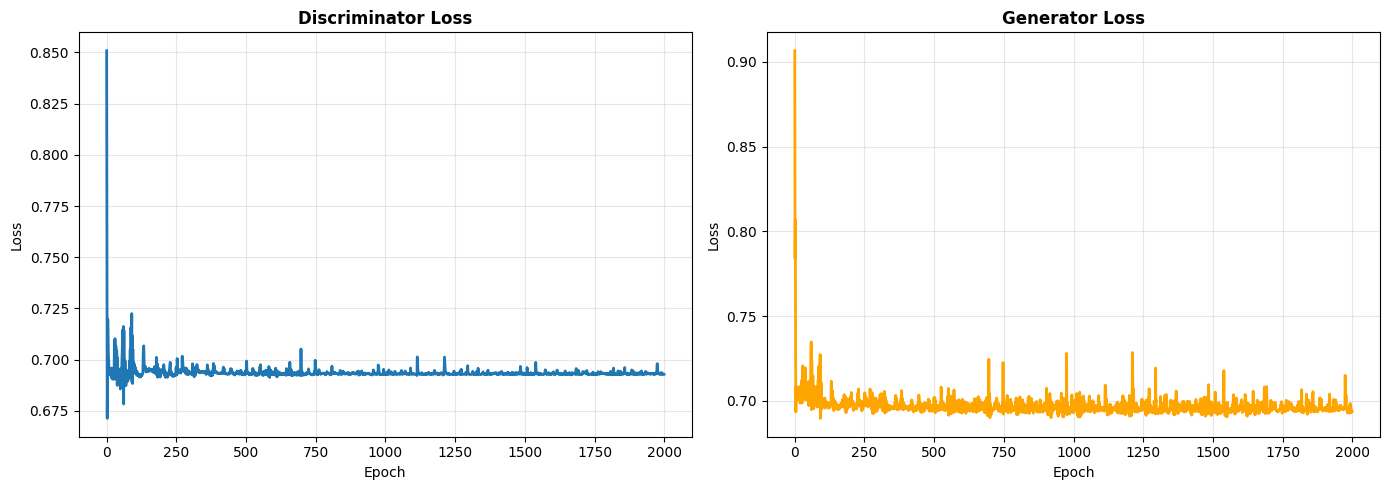

In [21]:
# === SECTION 14: Plot Training Loss ===

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(disc_losses, linewidth=2)
axes[0].set_title('Discriminator Loss', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(alpha=0.3)

axes[1].plot(gen_losses, linewidth=2, color='orange')
axes[1].set_title('Generator Loss', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
# === SECTION 15: Prepare Backtest Data (SINGLE SOURCE OF TRUTH) ===

# Filter backtest data to specific period
df_backtest = df_1m_filtered[
    (df_1m_filtered['date'] >= BACKTEST_START) & 
    (df_1m_filtered['date'] <= BACKTEST_END)
].copy()

print(f"\nBacktest dataset: {len(df_backtest)} rows")
print(f"Date range: {df_backtest['date'].min().date()} to {df_backtest['date'].max().date()}")

# Filter VolGAN condition data to backtest period
mask_backtest = (dates_test_all >= BACKTEST_START) & (dates_test_all <= BACKTEST_END)
condition_test_backtest = condition_test_all[mask_backtest]
dates_test_backtest = dates_test_all[mask_backtest]

print(f"VolGAN test data available: {len(dates_test_backtest)} dates\n")


Backtest dataset: 2181138 rows
Date range: 2021-01-04 to 2023-08-31
VolGAN test data available: 670 dates



In [24]:
# === SECTION 16: Run Backtest ===

results_volgan = run_volgan_experiment(
    df_backtest, gen, M0_LIST,
    condition_test_backtest.cpu().numpy(),
    dates_test_backtest.to_numpy(),
    m, tau, max_windows=52, device=device
)

print(f"\n✓ Backtest complete: {results_volgan.shape[0]} windows")
results_volgan.head()


===== VolGAN: m0=0.75 =====
Window 1/31
Window 2/31
Window 3/31
Window 4/31
Window 5/31
Window 6/31
Window 7/31
Window 8/31
Window 9/31
Window 10/31
Window 11/31
Window 12/31
Window 13/31
Window 14/31
Window 15/31
Window 16/31
Window 17/31
Window 18/31
Window 19/31
Window 20/31
Window 21/31
Window 22/31
Window 23/31
Window 24/31
Window 25/31
Window 26/31
Window 27/31
Window 28/31
Window 29/31
Window 30/31
Window 31/31

===== VolGAN: m0=0.8 =====
Window 1/31
Window 2/31
Window 3/31
Window 4/31
Window 5/31
Window 6/31
Window 7/31
Window 8/31
Window 9/31
Window 10/31
Window 11/31
Window 12/31
Window 13/31
Window 14/31
Window 15/31
Window 16/31
Window 17/31
Window 18/31
Window 19/31
Window 20/31
Window 21/31
Window 22/31
Window 23/31
Window 24/31
Window 25/31
Window 26/31
Window 27/31
Window 28/31
Window 29/31
Window 30/31
Window 31/31

===== VolGAN: m0=0.9 =====
Window 1/31
Window 2/31
Window 3/31
Window 4/31
Window 5/31
Window 6/31
Window 7/31
Window 8/31
Window 9/31
Window 10/31
Window

/Users/user/Desktop/y3s1/qf209/VolGAN-replica/venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.911e-02, tolerance: 4.018e-02
  model = cd_fast.enet_coordinate_descent(
/Users/user/Desktop/y3s1/qf209/VolGAN-replica/venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.707e-02, tolerance: 3.799e-02
  model = cd_fast.enet_coordinate_descent(


Window 19/31
Window 20/31
Window 21/31
Window 22/31
Window 23/31
Window 24/31
Window 25/31
Window 26/31
Window 27/31
Window 28/31
Window 29/31
Window 30/31
Window 31/31

===== VolGAN: m0=1.1 =====
Window 1/31
Window 2/31
Window 3/31
Window 4/31
Window 5/31
Window 6/31
Window 7/31
Window 8/31
Window 9/31
Window 10/31
Window 11/31
Window 12/31
Window 13/31
Window 14/31
Window 15/31
Window 16/31
Window 17/31
Window 18/31
Window 19/31
Window 20/31
Window 21/31
Window 22/31
Window 23/31


/Users/user/Desktop/y3s1/qf209/VolGAN-replica/venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.286e-02, tolerance: 2.658e-02
  model = cd_fast.enet_coordinate_descent(


Window 24/31
Window 25/31
Window 26/31
Window 27/31
Window 28/31
Window 29/31
Window 30/31
Window 31/31

===== VolGAN: m0=1.2 =====
Window 1/31
Window 2/31
Window 3/31
Window 4/31
Window 5/31
Window 6/31
Window 7/31
Window 8/31
Window 9/31
Window 10/31
Window 11/31
Window 12/31
Window 13/31
Window 14/31
Window 15/31
Window 16/31
Window 17/31
Window 18/31
Window 19/31
Window 20/31
Window 21/31
Window 22/31
Window 23/31
Window 24/31
Window 25/31
Window 26/31
Window 27/31
Window 28/31
Window 29/31
Window 30/31
Window 31/31

===== VolGAN: m0=1.25 =====
Window 1/31
Window 2/31
Window 3/31
Window 4/31
Window 5/31
Window 6/31
Window 7/31
Window 8/31
Window 9/31
Window 10/31
Window 11/31
Window 12/31
Window 13/31
Window 14/31
Window 15/31
Window 16/31
Window 17/31
Window 18/31
Window 19/31
Window 20/31
Window 21/31
Window 22/31
Window 23/31
Window 24/31
Window 25/31
Window 26/31
Window 27/31
Window 28/31
Window 29/31
Window 30/31
Window 31/31

✓ Backtest complete: 60 windows


,start,end,m0,V0,V_T,Pi_T,tracking_error,pnl_unhedged,pnl_hedged,strategy
0,2021-01-04,2021-02-03,0.75,931.000,1057.075,1051.954410,5.120590,126.075,120.954410,VolGAN
1,2021-02-03,2021-03-05,0.75,956.625,966.975,969.220602,-2.245602,10.350,12.595602,VolGAN
2,2021-05-05,2021-06-04,0.75,1039.175,1103.725,1099.412982,4.312018,64.550,60.237982,VolGAN
3,2021-06-04,2021-07-06,0.75,1059.575,1172.850,1169.537822,3.312178,113.275,109.962822,VolGAN
4,2021-08-04,2021-09-02,0.75,1100.950,1234.650,1231.441552,3.208448,133.700,130.491552,VolGAN


In [25]:
# === SECTION 17: Summary Statistics ===

summary_volgan = results_volgan.groupby('m0')['tracking_error'].agg([
    ('Count', 'count'),
    ('Mean', 'mean'),
    ('Median', 'median'),
    ('Std Dev', 'std'),
    ('Min', 'min'),
    ('Max', 'max'),
    ('VaR 5%', lambda x: x.quantile(0.05)),
    ('VaR 1%', lambda x: x.quantile(0.01))
]).round(3)

print("\n" + "="*80)
print("VolGAN TRACKING ERROR SUMMARY")
print("="*80)
print(summary_volgan)
print("="*80)


VolGAN TRACKING ERROR SUMMARY
      Count   Mean  Median  Std Dev     Min     Max  VaR 5%  VaR 1%
m0                                                                 
0.75     13  2.870   3.208    3.710  -5.266   8.383  -3.454  -4.903
0.80     15  2.313   1.992    4.197  -6.507  10.295  -3.751  -5.956
0.90     26  1.714   2.927    9.502 -23.604  17.027 -13.117 -21.032
1.10      6  8.213   6.369    7.895   1.127  21.387   1.326   1.167


/var/folders/lf/j1p7b9893pb19dwl2jcxhw900000gn/T/ipykernel_70019/1330267191.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='m0', y='tracking_error', data=results_volgan, palette='Set2')


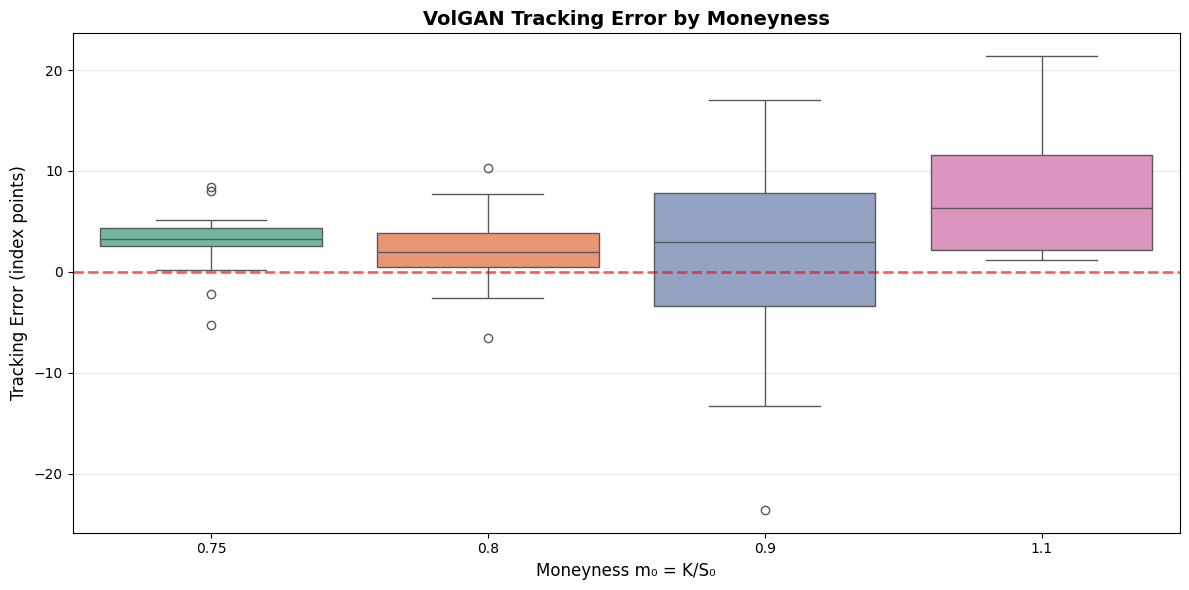

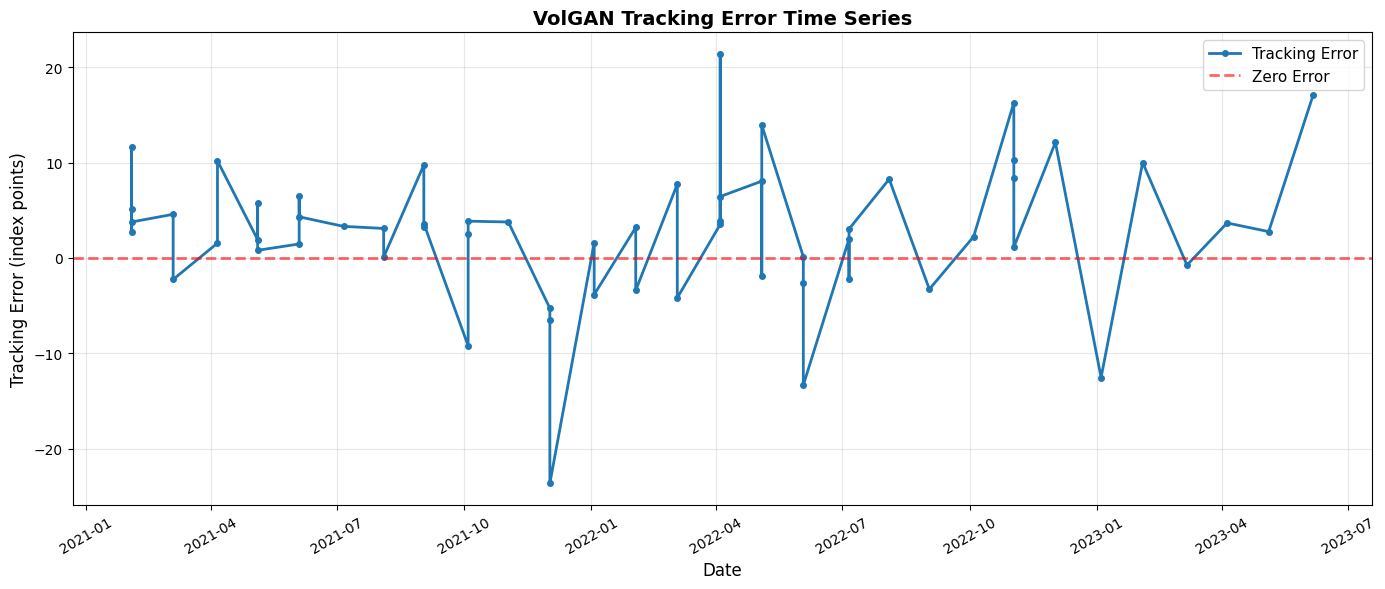

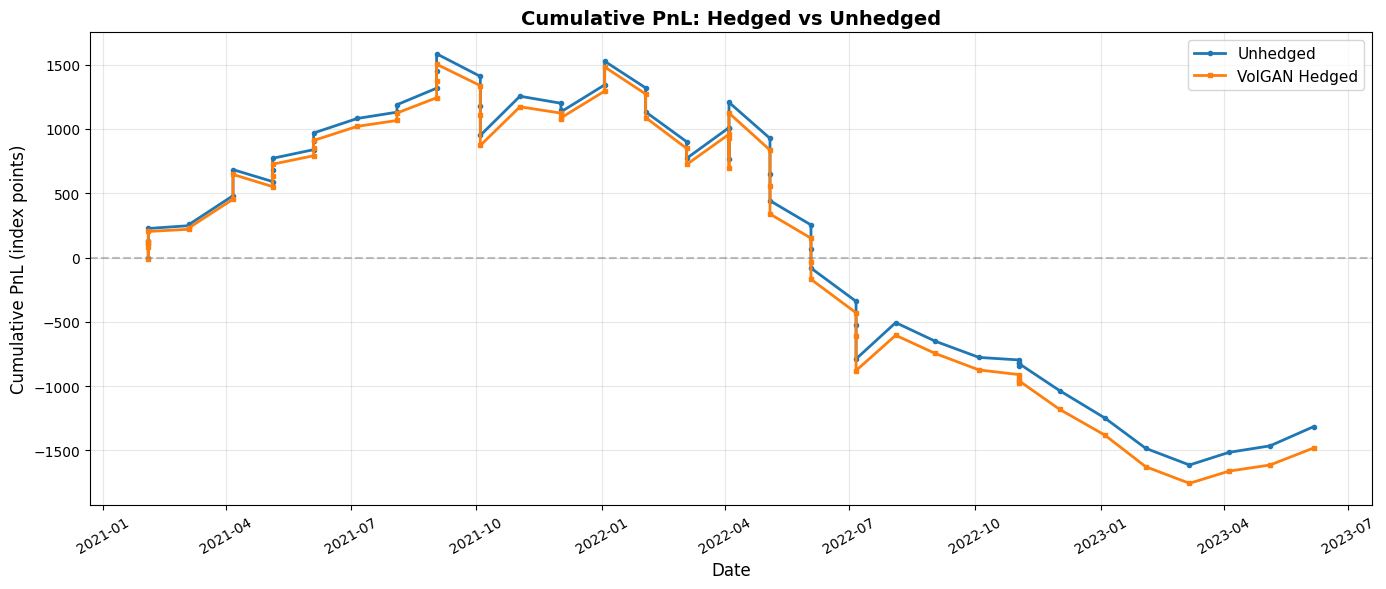

In [26]:
# === SECTION 18: Visualizations ===

# Box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='m0', y='tracking_error', data=results_volgan, palette='Set2')
plt.title('VolGAN Tracking Error by Moneyness', fontsize=14, fontweight='bold')
plt.xlabel('Moneyness m₀ = K/S₀', fontsize=12)
plt.ylabel('Tracking Error (index points)', fontsize=12)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.6, linewidth=2)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Time series
res = results_volgan.sort_values('end').reset_index(drop=True)
plt.figure(figsize=(14, 6))
plt.plot(res['end'], res['tracking_error'], marker='o', linewidth=2, markersize=4, label='Tracking Error')
plt.axhline(0, color='red', linestyle='--', alpha=0.6, linewidth=2, label='Zero Error')
plt.title('VolGAN Tracking Error Time Series', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Tracking Error (index points)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Cumulative PnL
res['cum_unhedged'] = res['pnl_unhedged'].cumsum()
res['cum_hedged'] = res['pnl_hedged'].cumsum()

plt.figure(figsize=(14, 6))
plt.plot(res['end'], res['cum_unhedged'], label='Unhedged', linewidth=2, marker='o', markersize=3)
plt.plot(res['end'], res['cum_hedged'], label='VolGAN Hedged', linewidth=2, marker='s', markersize=3)
plt.title('Cumulative PnL: Hedged vs Unhedged', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative PnL (index points)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


GENERATING 3D IV SURFACE VISUALIZATIONS



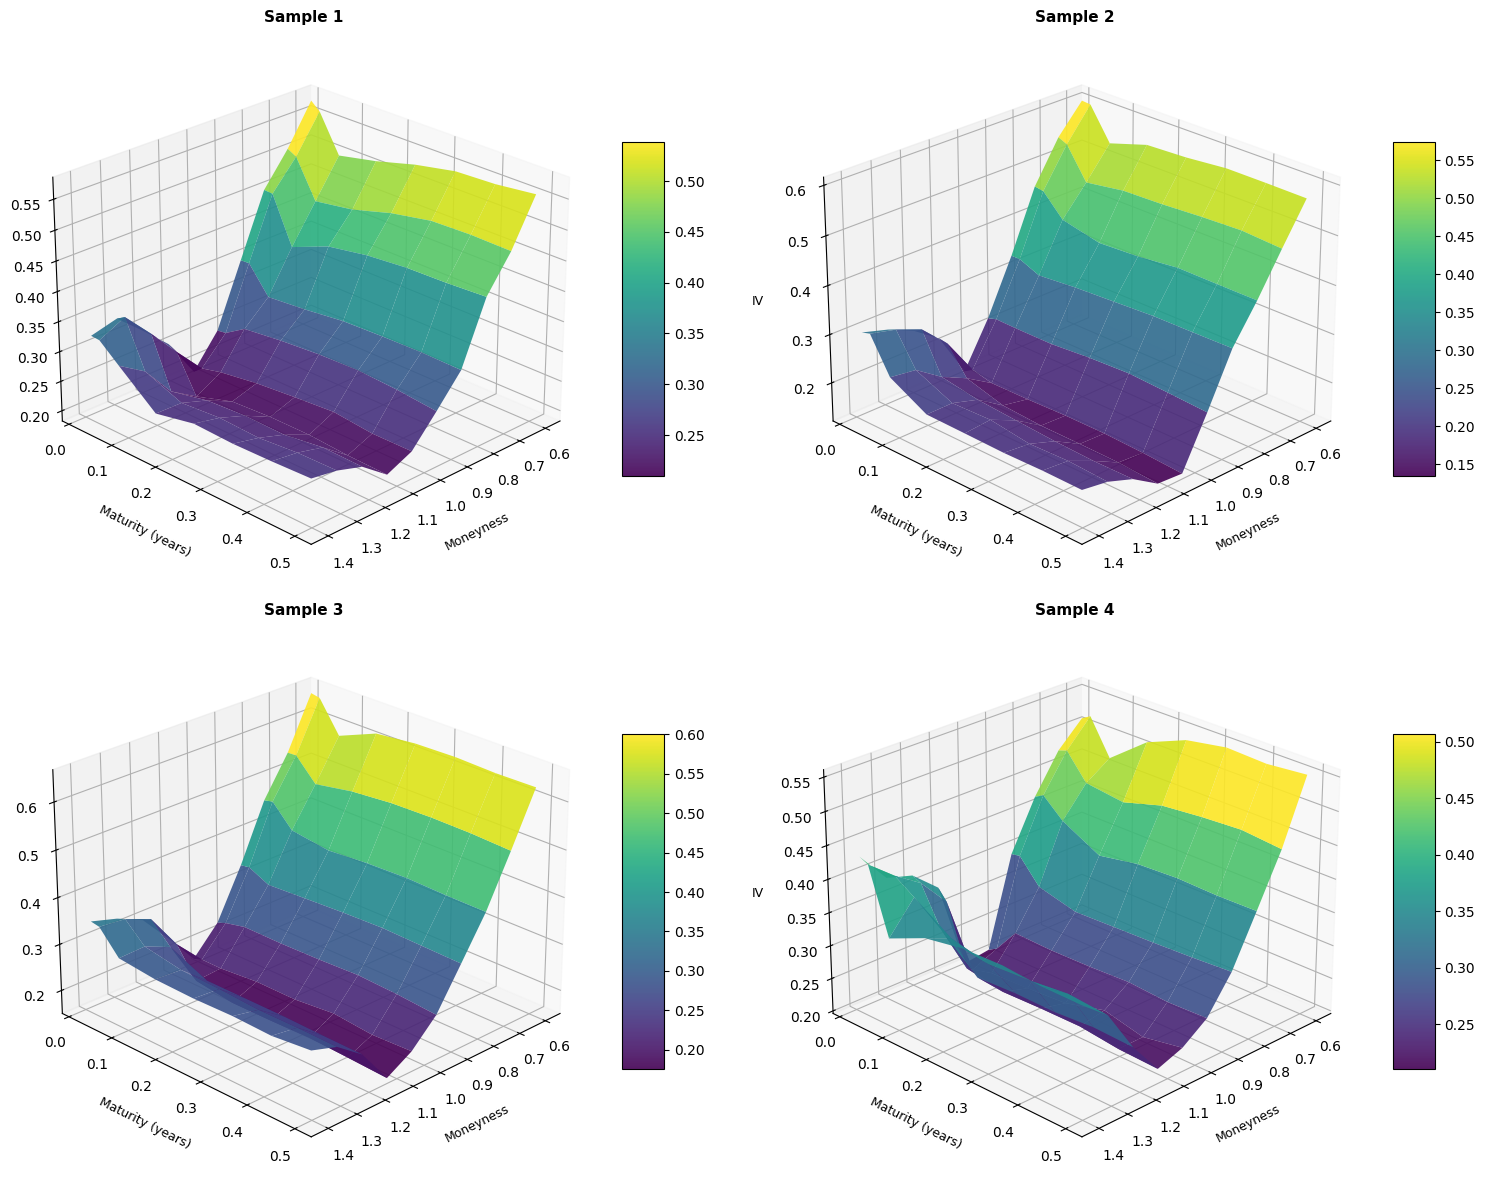

✓ Saved: iv_surfaces_samples_grid.png

Generating Real vs Generated Surface comparison...



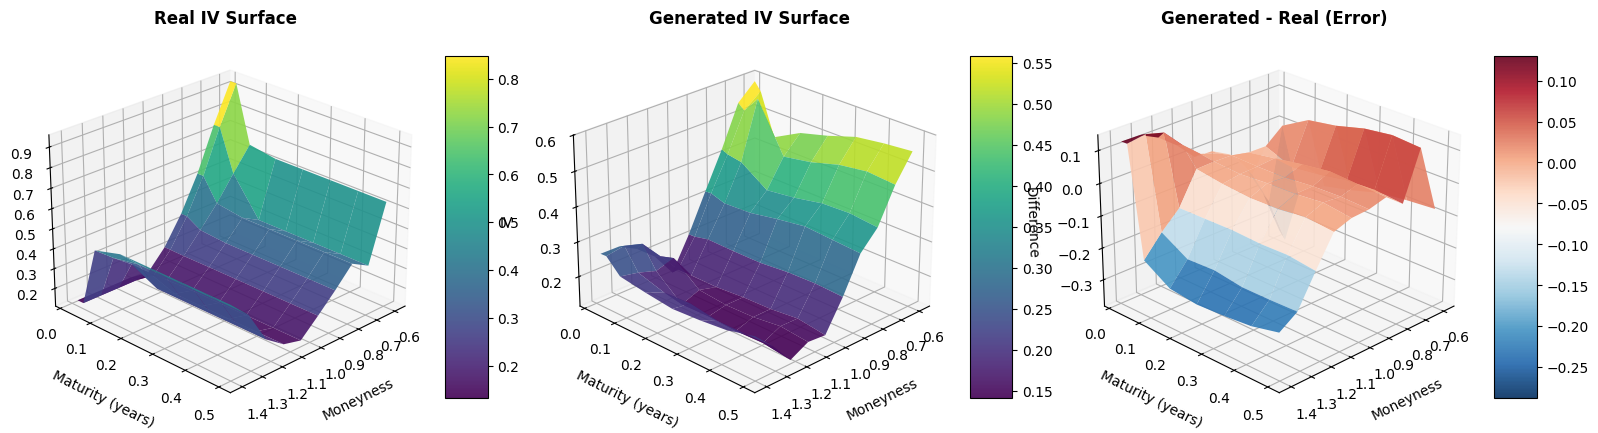

✓ Saved: iv_surface_comparison_real_vs_generated.png

Generating 2D slice visualizations...



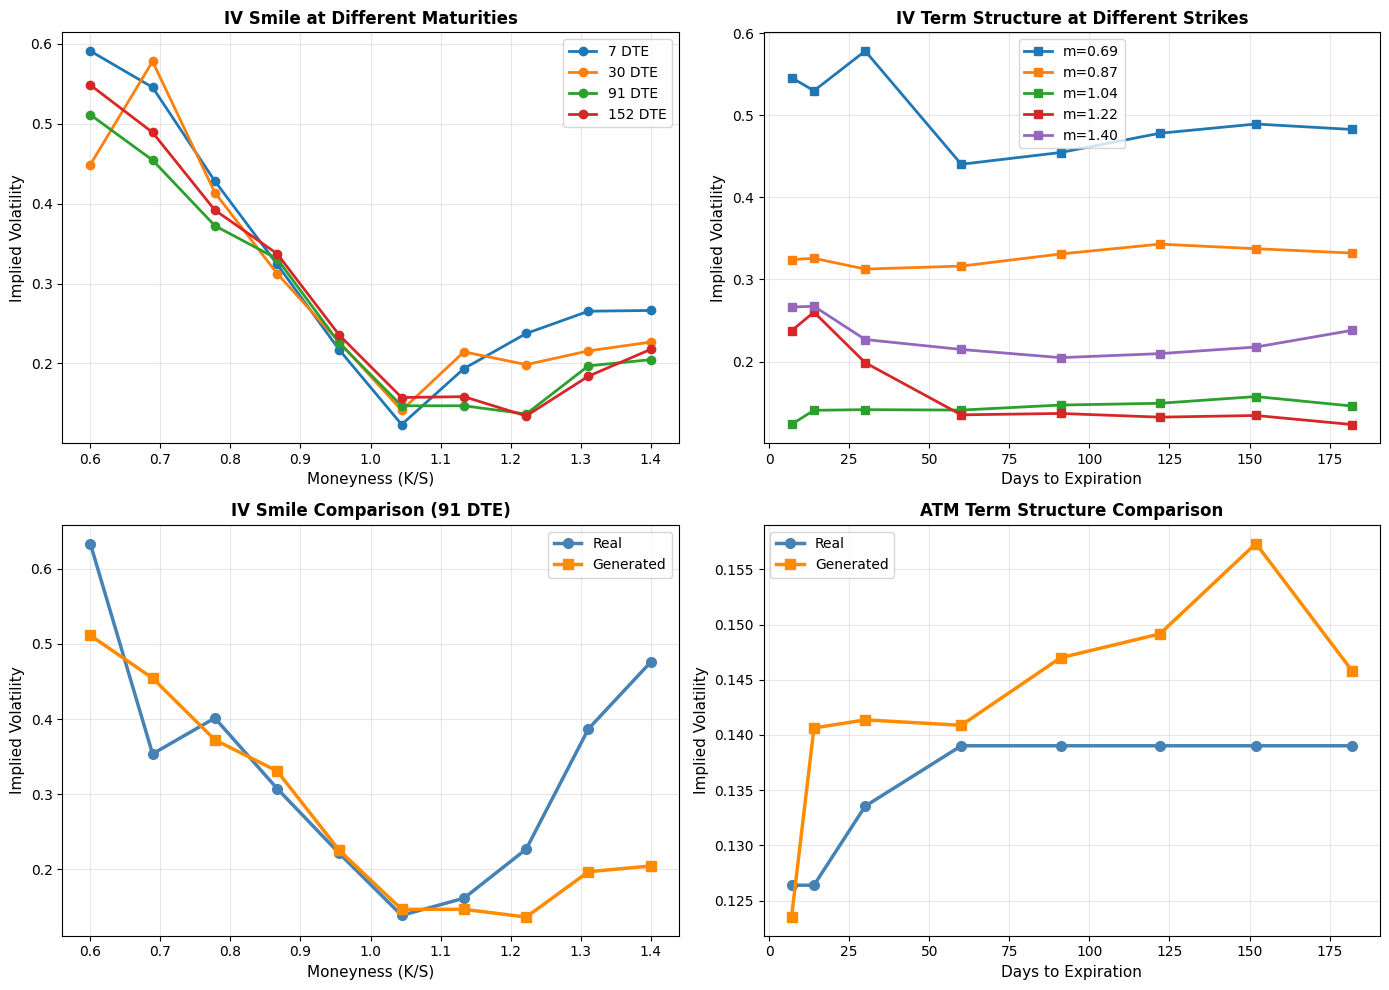

✓ Saved: iv_surface_slices_2d.png

Generating heatmap visualizations...



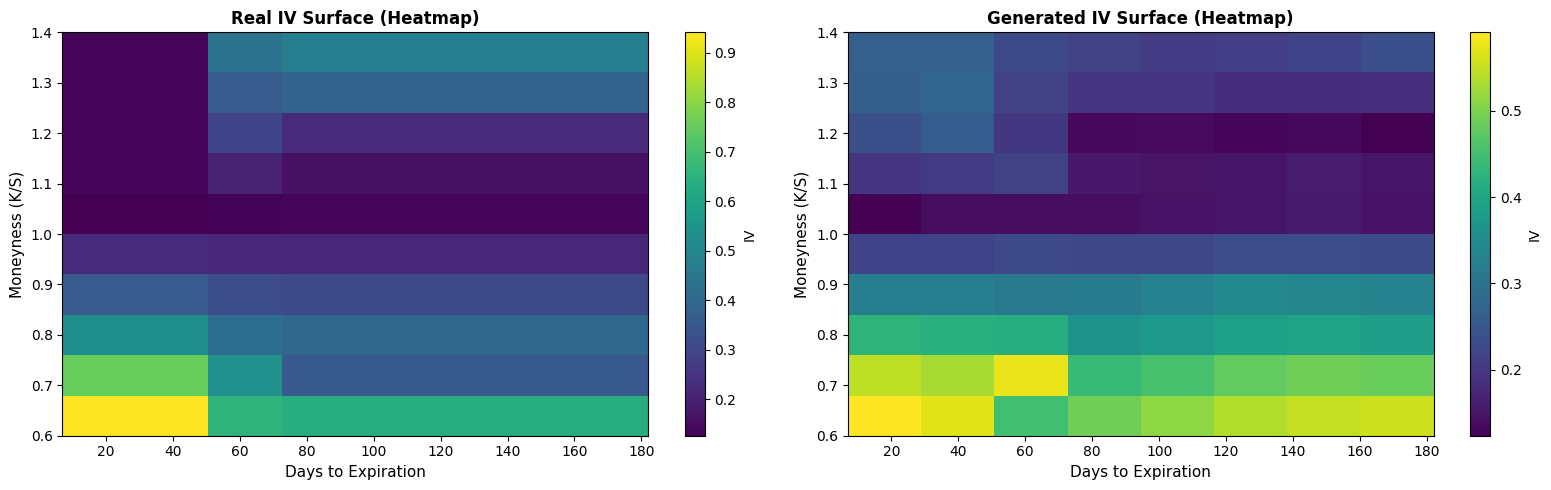

✓ Saved: iv_surface_heatmaps.png

✓ ALL VISUALIZATIONS COMPLETE

Generated files:
  1. iv_surfaces_samples_grid.png - 4 random generated surfaces
  2. iv_surface_comparison_real_vs_generated.png - Side-by-side comparison
  3. iv_surface_slices_2d.png - 2D slices (smile, term structure)
  4. iv_surface_heatmaps.png - Heatmap representations



In [28]:
# %%
# === SECTION 17B: 3D IV SURFACE VISUALIZATIONS ===

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def plot_iv_surface_3d(surface, m_grid, tau_grid, title="", figsize=(10, 8)):
    """
    Create a 3D surface plot of IV surface.
    
    Args:
        surface: Flattened IV surface (1D array of 80 values)
        m_grid: Moneyness grid (10 values)
        tau_grid: Tau grid (8 values in years)
        title: Plot title
        figsize: Figure size
    """
    lk, lt = len(m_grid), len(tau_grid)
    
    # Reshape if flattened
    if surface.ndim == 1:
        surface = surface.reshape(lt, lk).T  # Shape: (lk, lt)
    
    # Create meshgrid
    M, T = np.meshgrid(m_grid, tau_grid, indexing='ij')
    
    # Create figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot surface
    surf = ax.plot_surface(M, T, surface, cmap=cm.viridis, 
                          linewidth=0, antialiased=True, alpha=0.9)
    
    # Labels and formatting
    ax.set_xlabel('Moneyness (K/S)', fontsize=11, labelpad=10)
    ax.set_ylabel('Maturity (years)', fontsize=11, labelpad=10)
    ax.set_zlabel('Implied Volatility', fontsize=11, labelpad=10)
    ax.set_title(title, fontsize=13, fontweight='bold', pad=20)
    
    # Viewing angle (adjust as needed)
    ax.view_init(elev=25, azim=45)
    
    # Color bar
    cbar = fig.colorbar(surf, ax=ax, shrink=0.6, aspect=8, pad=0.1)
    cbar.set_label('IV', fontsize=10)
    
    # Grid
    ax.grid(True, alpha=0.3)
    
    return fig, ax

# %%
# === SECTION 17C: Generate Multiple Surface Samples ===

print("\n" + "="*70)
print("GENERATING 3D IV SURFACE VISUALIZATIONS")
print("="*70 + "\n")

gen.eval()

# Generate 4 surfaces for display (Sample 1-4)
fig_multi = plt.figure(figsize=(16, 12))

n_display = 4
with torch.no_grad():
    for sample_idx in range(n_display):
        # Random condition from test set
        cond_idx = np.random.randint(0, condition_test_all.shape[0])
        cond = condition_test_all[cond_idx:cond_idx+1, :].to(device)
        surface_past = cond[:, 3:]
        
        # Generate surface
        noise = torch.randn((1, NOISE_DIM), device=device)
        fake = gen(noise, cond)
        gen_surface = torch.exp(fake[:, 1:] + surface_past).cpu().numpy()[0]
        gen_surface_grid = gen_surface.reshape(len(m), len(tau))
        
        # Plot in subplot
        ax = fig_multi.add_subplot(2, 2, sample_idx + 1, projection='3d')
        
        M, T = np.meshgrid(m, tau, indexing='ij')
        surf = ax.plot_surface(M, T, gen_surface_grid, cmap=cm.viridis,
                              linewidth=0, antialiased=True, alpha=0.9)
        
        ax.set_xlabel('Moneyness', fontsize=9, labelpad=8)
        ax.set_ylabel('Maturity (years)', fontsize=9, labelpad=8)
        ax.set_zlabel('IV', fontsize=9, labelpad=8)
        ax.set_title(f'Sample {sample_idx + 1}', fontsize=11, fontweight='bold')
        ax.view_init(elev=25, azim=45)
        
        fig_multi.colorbar(surf, ax=ax, shrink=0.6, aspect=8, pad=0.05)

plt.tight_layout()
plt.savefig('iv_surfaces_samples_grid.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: iv_surfaces_samples_grid.png\n")

# %%
# === SECTION 17D: Compare Real vs Generated Surfaces ===

print("Generating Real vs Generated Surface comparison...\n")

# Pick one condition
cond_idx = 5
cond = condition_test_all[cond_idx:cond_idx+1, :].to(device)
surface_past = cond[:, 3:]

# Real surface
real_surface = torch.exp(surface_past).cpu().numpy()[0]
real_surface_grid = real_surface.reshape(len(m), len(tau))

# Generated surface
with torch.no_grad():
    noise = torch.randn((1, NOISE_DIM), device=device)
    fake = gen(noise, cond)
    gen_surface = torch.exp(fake[:, 1:] + surface_past).cpu().numpy()[0]
    gen_surface_grid = gen_surface.reshape(len(m), len(tau))

# Plot side-by-side
fig = plt.figure(figsize=(16, 6))

M, T = np.meshgrid(m, tau, indexing='ij')

# Real
ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(M, T, real_surface_grid, cmap=cm.viridis,
                        linewidth=0, antialiased=True, alpha=0.9)
ax1.set_xlabel('Moneyness', fontsize=10, labelpad=8)
ax1.set_ylabel('Maturity (years)', fontsize=10, labelpad=8)
ax1.set_zlabel('IV', fontsize=10, labelpad=8)
ax1.set_title('Real IV Surface', fontsize=12, fontweight='bold')
ax1.view_init(elev=25, azim=45)
fig.colorbar(surf1, ax=ax1, shrink=0.6, aspect=8)

# Generated
ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(M, T, gen_surface_grid, cmap=cm.viridis,
                        linewidth=0, antialiased=True, alpha=0.9)
ax2.set_xlabel('Moneyness', fontsize=10, labelpad=8)
ax2.set_ylabel('Maturity (years)', fontsize=10, labelpad=8)
ax2.set_zlabel('IV', fontsize=10, labelpad=8)
ax2.set_title('Generated IV Surface', fontsize=12, fontweight='bold')
ax2.view_init(elev=25, azim=45)
fig.colorbar(surf2, ax=ax2, shrink=0.6, aspect=8)

# Difference
diff_surface = gen_surface_grid - real_surface_grid
ax3 = fig.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(M, T, diff_surface, cmap=cm.RdBu_r,
                        linewidth=0, antialiased=True, alpha=0.9)
ax3.set_xlabel('Moneyness', fontsize=10, labelpad=8)
ax3.set_ylabel('Maturity (years)', fontsize=10, labelpad=8)
ax3.set_zlabel('Difference', fontsize=10, labelpad=8)
ax3.set_title('Generated - Real (Error)', fontsize=12, fontweight='bold')
ax3.view_init(elev=25, azim=45)
fig.colorbar(surf3, ax=ax3, shrink=0.6, aspect=8)

plt.tight_layout()
plt.savefig('iv_surface_comparison_real_vs_generated.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: iv_surface_comparison_real_vs_generated.png\n")

# %%
# === SECTION 17E: 2D Slice Visualizations (Optional) ===

print("Generating 2D slice visualizations...\n")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Slice 1: IV across strikes at different maturities
ax = axes[0, 0]
for tau_idx in [0, 2, 4, 6]:  # Different maturities
    ax.plot(m, gen_surface_grid[:, tau_idx], marker='o', 
           label=f'{tau[tau_idx]*365:.0f} DTE', linewidth=2, markersize=6)
ax.set_xlabel('Moneyness (K/S)', fontsize=11)
ax.set_ylabel('Implied Volatility', fontsize=11)
ax.set_title('IV Smile at Different Maturities', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Slice 2: IV term structure at different strikes
ax = axes[0, 1]
for m_idx in [1, 3, 5, 7, 9]:  # Different moneyness
    ax.plot(tau*365, gen_surface_grid[m_idx, :], marker='s', 
           label=f'm={m[m_idx]:.2f}', linewidth=2, markersize=6)
ax.set_xlabel('Days to Expiration', fontsize=11)
ax.set_ylabel('Implied Volatility', fontsize=11)
ax.set_title('IV Term Structure at Different Strikes', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Slice 3: Real vs Generated - Smile
ax = axes[1, 0]
tau_mid = 4  # Mid-term maturity
ax.plot(m, real_surface_grid[:, tau_mid], marker='o', linewidth=2.5, 
       markersize=7, label='Real', color='steelblue')
ax.plot(m, gen_surface_grid[:, tau_mid], marker='s', linewidth=2.5, 
       markersize=7, label='Generated', color='darkorange')
ax.set_xlabel('Moneyness (K/S)', fontsize=11)
ax.set_ylabel('Implied Volatility', fontsize=11)
ax.set_title(f'IV Smile Comparison ({tau[tau_mid]*365:.0f} DTE)', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Slice 4: Real vs Generated - Term Structure
ax = axes[1, 1]
m_atm = np.argmin(np.abs(m - 1.0))  # ATM moneyness
ax.plot(tau*365, real_surface_grid[m_atm, :], marker='o', linewidth=2.5, 
       markersize=7, label='Real', color='steelblue')
ax.plot(tau*365, gen_surface_grid[m_atm, :], marker='s', linewidth=2.5, 
       markersize=7, label='Generated', color='darkorange')
ax.set_xlabel('Days to Expiration', fontsize=11)
ax.set_ylabel('Implied Volatility', fontsize=11)
ax.set_title('ATM Term Structure Comparison', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('iv_surface_slices_2d.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: iv_surface_slices_2d.png\n")

# %%
# === SECTION 17F: Heatmap Visualization ===

print("Generating heatmap visualizations...\n")

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Real surface heatmap
im1 = axes[0].imshow(real_surface_grid, aspect='auto', origin='lower', cmap='viridis',
                    extent=[tau[0]*365, tau[-1]*365, m[0], m[-1]])
axes[0].set_xlabel('Days to Expiration', fontsize=11)
axes[0].set_ylabel('Moneyness (K/S)', fontsize=11)
axes[0].set_title('Real IV Surface (Heatmap)', fontsize=12, fontweight='bold')
cbar1 = plt.colorbar(im1, ax=axes[0])
cbar1.set_label('IV', fontsize=10)

# Generated surface heatmap
im2 = axes[1].imshow(gen_surface_grid, aspect='auto', origin='lower', cmap='viridis',
                    extent=[tau[0]*365, tau[-1]*365, m[0], m[-1]])
axes[1].set_xlabel('Days to Expiration', fontsize=11)
axes[1].set_ylabel('Moneyness (K/S)', fontsize=11)
axes[1].set_title('Generated IV Surface (Heatmap)', fontsize=12, fontweight='bold')
cbar2 = plt.colorbar(im2, ax=axes[1])
cbar2.set_label('IV', fontsize=10)

plt.tight_layout()
plt.savefig('iv_surface_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: iv_surface_heatmaps.png\n")

print("="*70)
print("✓ ALL VISUALIZATIONS COMPLETE")
print("="*70)
print("\nGenerated files:")
print("  1. iv_surfaces_samples_grid.png - 4 random generated surfaces")
print("  2. iv_surface_comparison_real_vs_generated.png - Side-by-side comparison")
print("  3. iv_surface_slices_2d.png - 2D slices (smile, term structure)")
print("  4. iv_surface_heatmaps.png - Heatmap representations")
print("="*70 + "\n")



GENERATING REAL vs GENERATED SURFACE COMPARISONS

Selecting test days and generating comparison surfaces...

✓ Saved: surface_comparison_test_day_000_2021-01-04.png


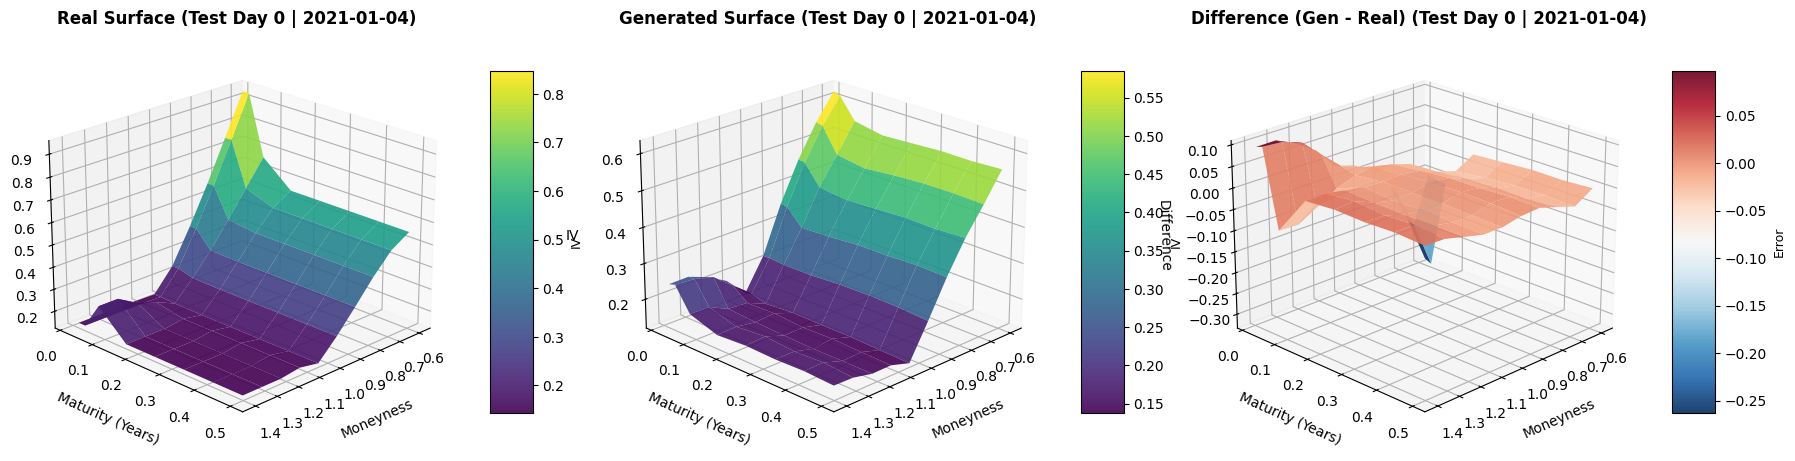

Day 1: 2021-01-04 | MAE: 0.0385 | RMSE: 0.0723

✓ Saved: surface_comparison_test_day_167_2021-09-01.png


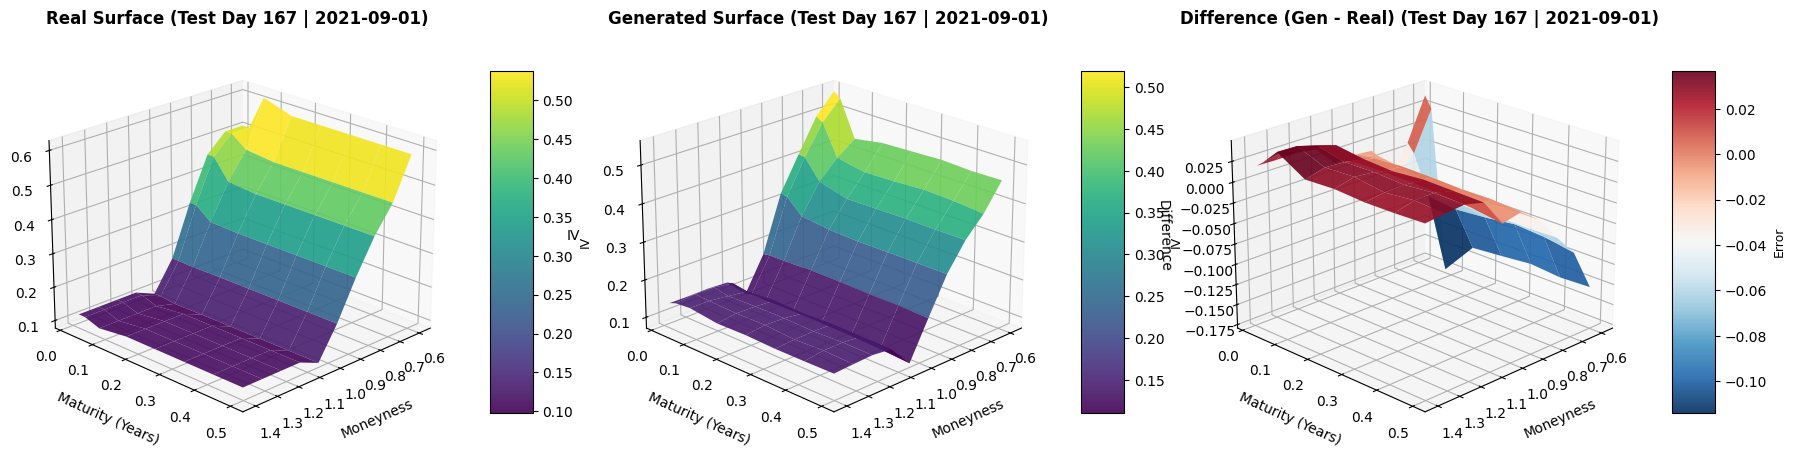

Day 2: 2021-09-01 | MAE: 0.0353 | RMSE: 0.0496

✓ Saved: surface_comparison_test_day_335_2022-05-03.png


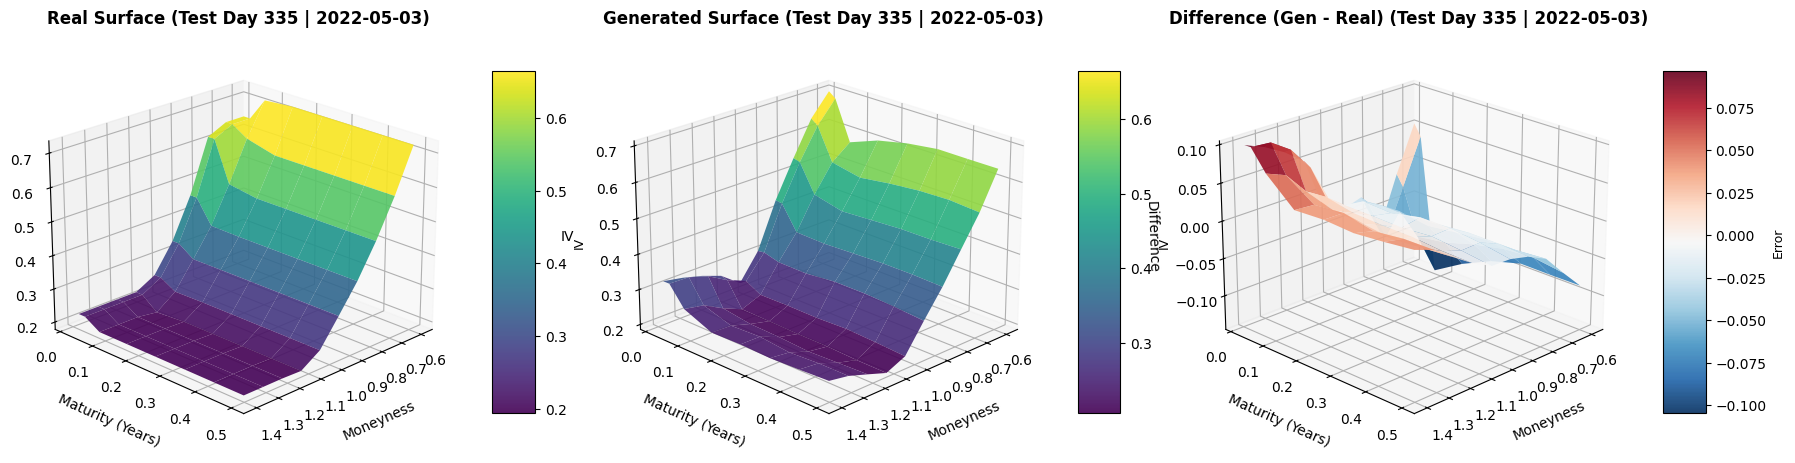

Day 3: 2022-05-03 | MAE: 0.0394 | RMSE: 0.0508


SYSTEMATIC EVALUATION ACROSS ALL TEST DAYS



Evaluating surfaces: 100%|██████████| 10/10 [00:00<00:00, 2086.93it/s]


----------------------------------------------------------------------
ACROSS-TIME SURFACE QUALITY SUMMARY
----------------------------------------------------------------------

MAE (Mean Absolute Error):
  Mean: 0.0399
  Std: 0.0134
  Min: 0.0194
  Max: 0.0728

RMSE (Root Mean Squared Error):
  Mean: 0.0609
  Std: 0.0164

Correlation with Real:
  Mean: 0.9254
  Std: 0.0625

Smile Error:
  Mean: 0.0205
  Std: 0.0166



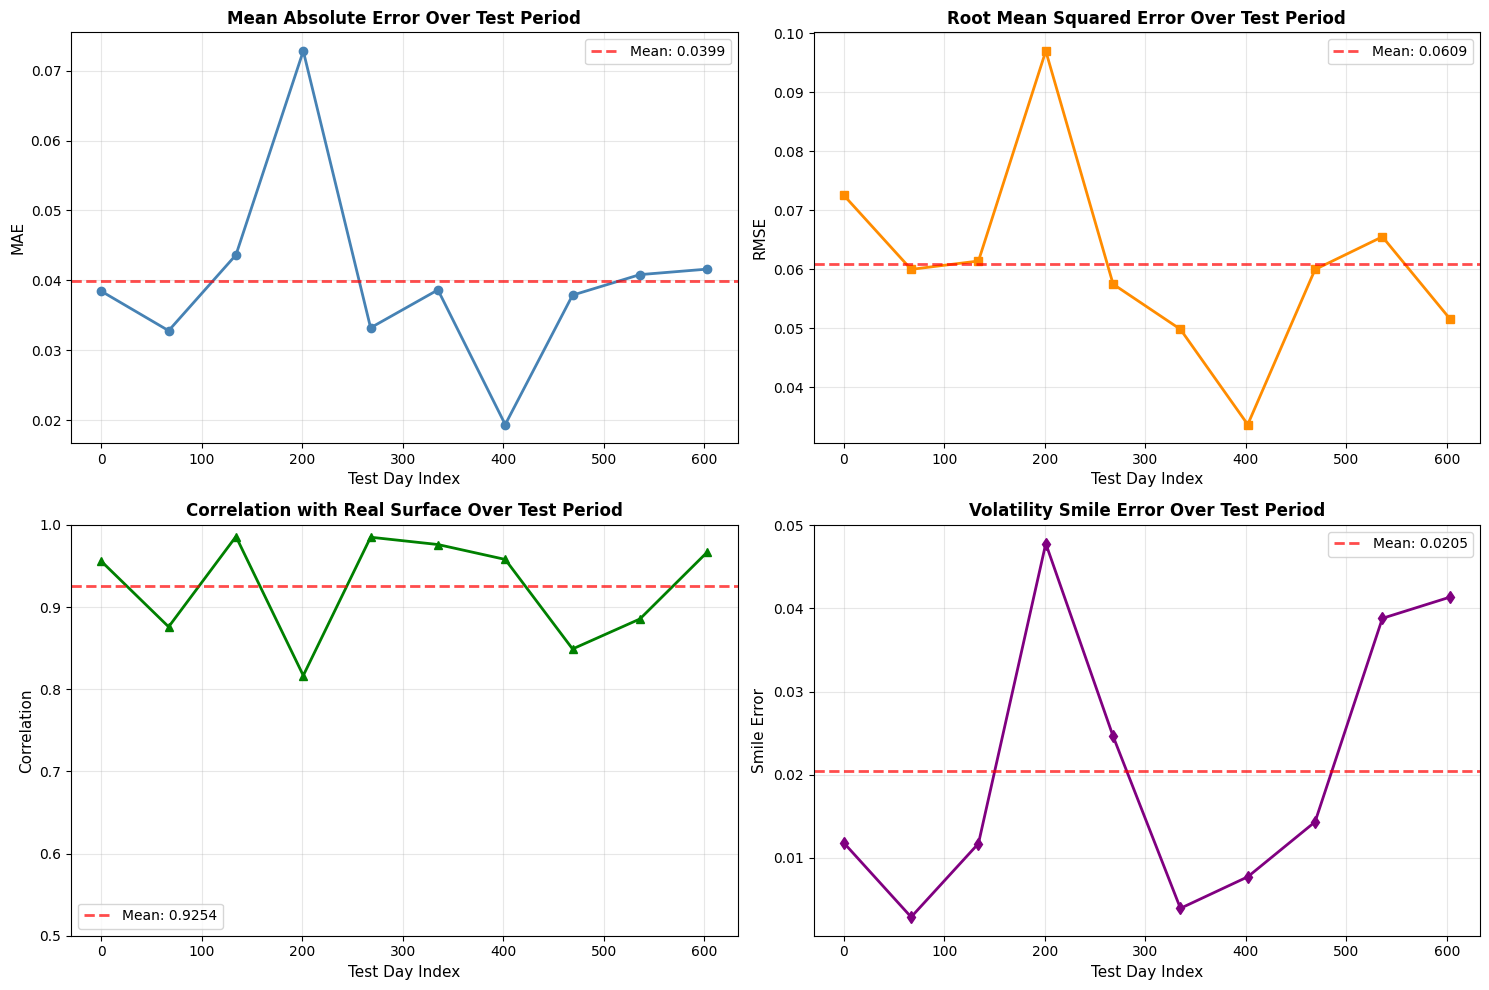

✓ Saved: surface_quality_time_series.png

✓ Saved: surface_comparison_metrics.csv

✓ SURFACE COMPARISON ANALYSIS COMPLETE

Generated files:
  1. surface_comparison_test_day_*.png - Real vs Generated comparisons
  2. surface_quality_time_series.png - Error metrics over time
  3. surface_comparison_metrics.csv - Detailed metrics for all test days



In [30]:
# %%
# === SECTION 17G: REAL vs GENERATED SURFACE COMPARISON ACROSS TEST DAYS ===

print("\n" + "="*70)
print("GENERATING REAL vs GENERATED SURFACE COMPARISONS")
print("="*70 + "\n")

def compare_real_vs_generated_3panel(real_surface, gen_surface, m_grid, tau_grid, 
                                     date_str="", save_path=None, figsize=(18, 6)):
    """
    Create 3-panel comparison: Real | Generated | Difference
    
    Args:
        real_surface: Real IV surface (flattened or 2D)
        gen_surface: Generated IV surface (flattened or 2D)
        m_grid: Moneyness grid
        tau_grid: Tau grid (in years)
        date_str: Date string for title
        save_path: Path to save figure
        figsize: Figure size
    """
    lk, lt = len(m_grid), len(tau_grid)
    
    # Reshape if needed
    if real_surface.ndim == 1:
        real_surface = real_surface.reshape(lt, lk).T
    if gen_surface.ndim == 1:
        gen_surface = gen_surface.reshape(lt, lk).T
    
    # Create meshgrid
    M, T = np.meshgrid(m_grid, tau_grid, indexing='ij')
    
    # Create figure with 3 subplots
    fig = plt.figure(figsize=figsize)
    
    # Panel 1: Real Surface
    ax1 = fig.add_subplot(131, projection='3d')
    surf1 = ax1.plot_surface(M, T, real_surface, cmap=cm.viridis,
                            linewidth=0, antialiased=True, alpha=0.9)
    ax1.set_xlabel('Moneyness', fontsize=10, labelpad=8)
    ax1.set_ylabel('Maturity (Years)', fontsize=10, labelpad=8)
    ax1.set_zlabel('IV', fontsize=10, labelpad=8)
    ax1.set_title(f'Real Surface{date_str}', fontsize=12, fontweight='bold')
    ax1.view_init(elev=22, azim=45)
    cbar1 = fig.colorbar(surf1, ax=ax1, shrink=0.6, aspect=8, pad=0.08)
    cbar1.set_label('IV', fontsize=9)
    
    # Panel 2: Generated Surface
    ax2 = fig.add_subplot(132, projection='3d')
    surf2 = ax2.plot_surface(M, T, gen_surface, cmap=cm.viridis,
                            linewidth=0, antialiased=True, alpha=0.9)
    ax2.set_xlabel('Moneyness', fontsize=10, labelpad=8)
    ax2.set_ylabel('Maturity (Years)', fontsize=10, labelpad=8)
    ax2.set_zlabel('IV', fontsize=10, labelpad=8)
    ax2.set_title(f'Generated Surface{date_str}', fontsize=12, fontweight='bold')
    ax2.view_init(elev=22, azim=45)
    cbar2 = fig.colorbar(surf2, ax=ax2, shrink=0.6, aspect=8, pad=0.08)
    cbar2.set_label('IV', fontsize=9)
    
    # Panel 3: Difference (Error)
    diff_surface = gen_surface - real_surface
    ax3 = fig.add_subplot(133, projection='3d')
    surf3 = ax3.plot_surface(M, T, diff_surface, cmap=cm.RdBu_r,
                            linewidth=0, antialiased=True, alpha=0.9)
    ax3.set_xlabel('Moneyness', fontsize=10, labelpad=8)
    ax3.set_ylabel('Maturity (Years)', fontsize=10, labelpad=8)
    ax3.set_zlabel('Difference', fontsize=10, labelpad=8)
    ax3.set_title(f'Difference (Gen - Real){date_str}', fontsize=12, fontweight='bold')
    ax3.view_init(elev=22, azim=45)
    cbar3 = fig.colorbar(surf3, ax=ax3, shrink=0.6, aspect=8, pad=0.08)
    cbar3.set_label('Error', fontsize=9)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved: {save_path}")
    
    plt.show()
    
    return fig, (ax1, ax2, ax3)

# %%
# === SECTION 17H: Generate Surfaces for Multiple Test Days ===

print("Selecting test days and generating comparison surfaces...\n")

# Select test days spread across the test period
# (Use different strategies: beginning, middle, end, high-vol, etc.)
n_test_days = condition_test_all.shape[0]

# Strategy: Pick days at different points in time
test_day_indices = [
    0,                          # First test day
    n_test_days // 4,           # 25% through test period
    n_test_days // 2,           # Middle of test period
    3 * n_test_days // 4,       # 75% through test period
    n_test_days - 1             # Last test day
]

# Generate comparison plots for selected days
gen.eval()

with torch.no_grad():
    for idx_num, test_day_idx in enumerate(test_day_indices[:3], 1):  # First 3
        # Get condition for this test day
        cond = condition_test_all[test_day_idx:test_day_idx+1, :].to(device)
        surface_past = cond[:, 3:]
        
        # Real surface
        real_surface_flat = torch.exp(surface_past).cpu().numpy()[0]
        real_surface = real_surface_flat.reshape(len(m), len(tau))
        
        # Generated surface (average of 10 samples for stability)
        gen_surfaces_samples = []
        for sample_num in range(10):
            noise = torch.randn((1, NOISE_DIM), device=device)
            fake = gen(noise, cond)
            gen_surf = torch.exp(fake[:, 1:] + surface_past).cpu().numpy()[0]
            gen_surfaces_samples.append(gen_surf.reshape(len(m), len(tau)))
        
        gen_surface = np.mean(gen_surfaces_samples, axis=0)
        
        # Compute statistics
        mae = np.mean(np.abs(gen_surface - real_surface))
        rmse = np.sqrt(np.mean((gen_surface - real_surface)**2))
        
        # Get date
        test_date = dates_test_all[test_day_idx]
        
        # Plot comparison
        compare_real_vs_generated_3panel(
            real_surface, gen_surface, m, tau,
            date_str=f" (Test Day {test_day_idx} | {test_date.date()})",
            save_path=f"surface_comparison_test_day_{test_day_idx:03d}_{test_date.date()}.png"
        )
        
        print(f"Day {idx_num}: {test_date.date()} | MAE: {mae:.4f} | RMSE: {rmse:.4f}\n")

# %%
# === SECTION 17I: SYSTEMATIC EVALUATION ACROSS ALL TEST DAYS ===

print("\n" + "="*70)
print("SYSTEMATIC EVALUATION ACROSS ALL TEST DAYS")
print("="*70 + "\n")

comparison_metrics = []

gen.eval()

with torch.no_grad():
    # Evaluate every 20th day to cover the whole test period
    step = max(1, n_test_days // 10)  # Roughly 10 comparisons
    
    for test_day_idx in tqdm(range(0, n_test_days, step), desc="Evaluating surfaces"):
        # Get condition
        cond = condition_test_all[test_day_idx:test_day_idx+1, :].to(device)
        surface_past = cond[:, 3:]
        
        # Real surface
        real_surface_flat = torch.exp(surface_past).cpu().numpy()[0]
        real_surface = real_surface_flat.reshape(len(m), len(tau))
        
        # Generated surface (average of 5 samples)
        gen_surfaces_samples = []
        for _ in range(5):
            noise = torch.randn((1, NOISE_DIM), device=device)
            fake = gen(noise, cond)
            gen_surf = torch.exp(fake[:, 1:] + surface_past).cpu().numpy()[0]
            gen_surfaces_samples.append(gen_surf.reshape(len(m), len(tau)))
        
        gen_surface = np.mean(gen_surfaces_samples, axis=0)
        
        # Compute metrics
        mae = np.mean(np.abs(gen_surface - real_surface))
        rmse = np.sqrt(np.mean((gen_surface - real_surface)**2))
        mape = np.mean(np.abs((gen_surface - real_surface) / (np.abs(real_surface) + 1e-8)))
        
        try:
            corr = np.corrcoef(gen_surface.flatten(), real_surface.flatten())[0, 1]
        except:
            corr = np.nan
        
        # Smile metrics
        atm_idx = np.argmin(np.abs(m - 1.0))
        atm_vol_real = real_surface[atm_idx, :].mean()
        atm_vol_gen = gen_surface[atm_idx, :].mean()
        
        otm_vol_real = np.concatenate([real_surface[:atm_idx, :], real_surface[atm_idx+1:, :]]).mean()
        otm_vol_gen = np.concatenate([gen_surface[:atm_idx, :], gen_surface[atm_idx+1:, :]]).mean()
        
        smile_real = otm_vol_real - atm_vol_real
        smile_gen = otm_vol_gen - atm_vol_gen
        
        comparison_metrics.append({
            'test_day_idx': test_day_idx,
            'date': dates_test_all[test_day_idx],
            'mae': mae,
            'rmse': rmse,
            'mape': mape,
            'correlation': corr,
            'smile_real': smile_real,
            'smile_gen': smile_gen,
            'smile_error': abs(smile_gen - smile_real)
        })

# Convert to DataFrame
metrics_df = pd.DataFrame(comparison_metrics)

print("\n" + "-"*70)
print("ACROSS-TIME SURFACE QUALITY SUMMARY")
print("-"*70)
print(f"\nMAE (Mean Absolute Error):")
print(f"  Mean: {metrics_df['mae'].mean():.4f}")
print(f"  Std: {metrics_df['mae'].std():.4f}")
print(f"  Min: {metrics_df['mae'].min():.4f}")
print(f"  Max: {metrics_df['mae'].max():.4f}")

print(f"\nRMSE (Root Mean Squared Error):")
print(f"  Mean: {metrics_df['rmse'].mean():.4f}")
print(f"  Std: {metrics_df['rmse'].std():.4f}")

print(f"\nCorrelation with Real:")
print(f"  Mean: {metrics_df['correlation'].mean():.4f}")
print(f"  Std: {metrics_df['correlation'].std():.4f}")

print(f"\nSmile Error:")
print(f"  Mean: {metrics_df['smile_error'].mean():.4f}")
print(f"  Std: {metrics_df['smile_error'].std():.4f}")

print("\n" + "="*70)

# %%
# === SECTION 17J: PLOT TIME SERIES OF ERRORS ===

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# MAE over time
axes[0, 0].plot(metrics_df['test_day_idx'], metrics_df['mae'], 
               marker='o', linewidth=2, markersize=6, color='steelblue')
axes[0, 0].axhline(metrics_df['mae'].mean(), color='red', linestyle='--', 
                   linewidth=2, alpha=0.7, label=f"Mean: {metrics_df['mae'].mean():.4f}")
axes[0, 0].set_xlabel('Test Day Index', fontsize=11)
axes[0, 0].set_ylabel('MAE', fontsize=11)
axes[0, 0].set_title('Mean Absolute Error Over Test Period', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)

# RMSE over time
axes[0, 1].plot(metrics_df['test_day_idx'], metrics_df['rmse'], 
               marker='s', linewidth=2, markersize=6, color='darkorange')
axes[0, 1].axhline(metrics_df['rmse'].mean(), color='red', linestyle='--', 
                   linewidth=2, alpha=0.7, label=f"Mean: {metrics_df['rmse'].mean():.4f}")
axes[0, 1].set_xlabel('Test Day Index', fontsize=11)
axes[0, 1].set_ylabel('RMSE', fontsize=11)
axes[0, 1].set_title('Root Mean Squared Error Over Test Period', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3)

# Correlation over time
axes[1, 0].plot(metrics_df['test_day_idx'], metrics_df['correlation'], 
               marker='^', linewidth=2, markersize=6, color='green')
axes[1, 0].axhline(metrics_df['correlation'].mean(), color='red', linestyle='--', 
                   linewidth=2, alpha=0.7, label=f"Mean: {metrics_df['correlation'].mean():.4f}")
axes[1, 0].set_xlabel('Test Day Index', fontsize=11)
axes[1, 0].set_ylabel('Correlation', fontsize=11)
axes[1, 0].set_title('Correlation with Real Surface Over Test Period', fontsize=12, fontweight='bold')
axes[1, 0].set_ylim([0.5, 1.0])
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(alpha=0.3)

# Smile error over time
axes[1, 1].plot(metrics_df['test_day_idx'], metrics_df['smile_error'], 
               marker='d', linewidth=2, markersize=6, color='purple')
axes[1, 1].axhline(metrics_df['smile_error'].mean(), color='red', linestyle='--', 
                   linewidth=2, alpha=0.7, label=f"Mean: {metrics_df['smile_error'].mean():.4f}")
axes[1, 1].set_xlabel('Test Day Index', fontsize=11)
axes[1, 1].set_ylabel('Smile Error', fontsize=11)
axes[1, 1].set_title('Volatility Smile Error Over Test Period', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('surface_quality_time_series.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: surface_quality_time_series.png\n")

# %%
# === SECTION 17K: SAVE COMPARISON METRICS ===

metrics_df.to_csv('surface_comparison_metrics.csv', index=False)
print("✓ Saved: surface_comparison_metrics.csv")

print("\n" + "="*70)
print("✓ SURFACE COMPARISON ANALYSIS COMPLETE")
print("="*70)
print("\nGenerated files:")
print("  1. surface_comparison_test_day_*.png - Real vs Generated comparisons")
print("  2. surface_quality_time_series.png - Error metrics over time")
print("  3. surface_comparison_metrics.csv - Detailed metrics for all test days")
print("="*70 + "\n")



REGIME-BASED ANALYSIS: VolGAN Performance by Moneyness

Analyzing 4 moneyness levels: [np.float64(0.75), np.float64(0.8), np.float64(0.9), np.float64(1.1)]

--------------------------------------------------------------------------------
DETAILED REGIME ANALYSIS
--------------------------------------------------------------------------------


REGIME: DEEP OTM PUT (m0=0.75)
Sample size: 13 windows

  Tracking Error:
    Mean:            2.870
    Median:          3.208
    Std Dev:         3.710
    Range:      [ -5.266,   8.383]

  PnL Analysis:
    Hedged PnL mean:       -45.764
    Hedged PnL std:        174.594
    Unhedged PnL mean:     -42.894
    Unhedged PnL std:      174.516

  Hedging Effectiveness:
    Ratio: 1.000 ⚠️  WEAK

REGIME: DEEP OTM PUT (m0=0.80)
Sample size: 15 windows

  Tracking Error:
    Mean:            2.313
    Median:          1.992
    Std Dev:         4.197
    Range:      [ -6.507,  10.295]

  PnL Analysis:
    Hedged PnL mean:       -10.160
    Hedged 

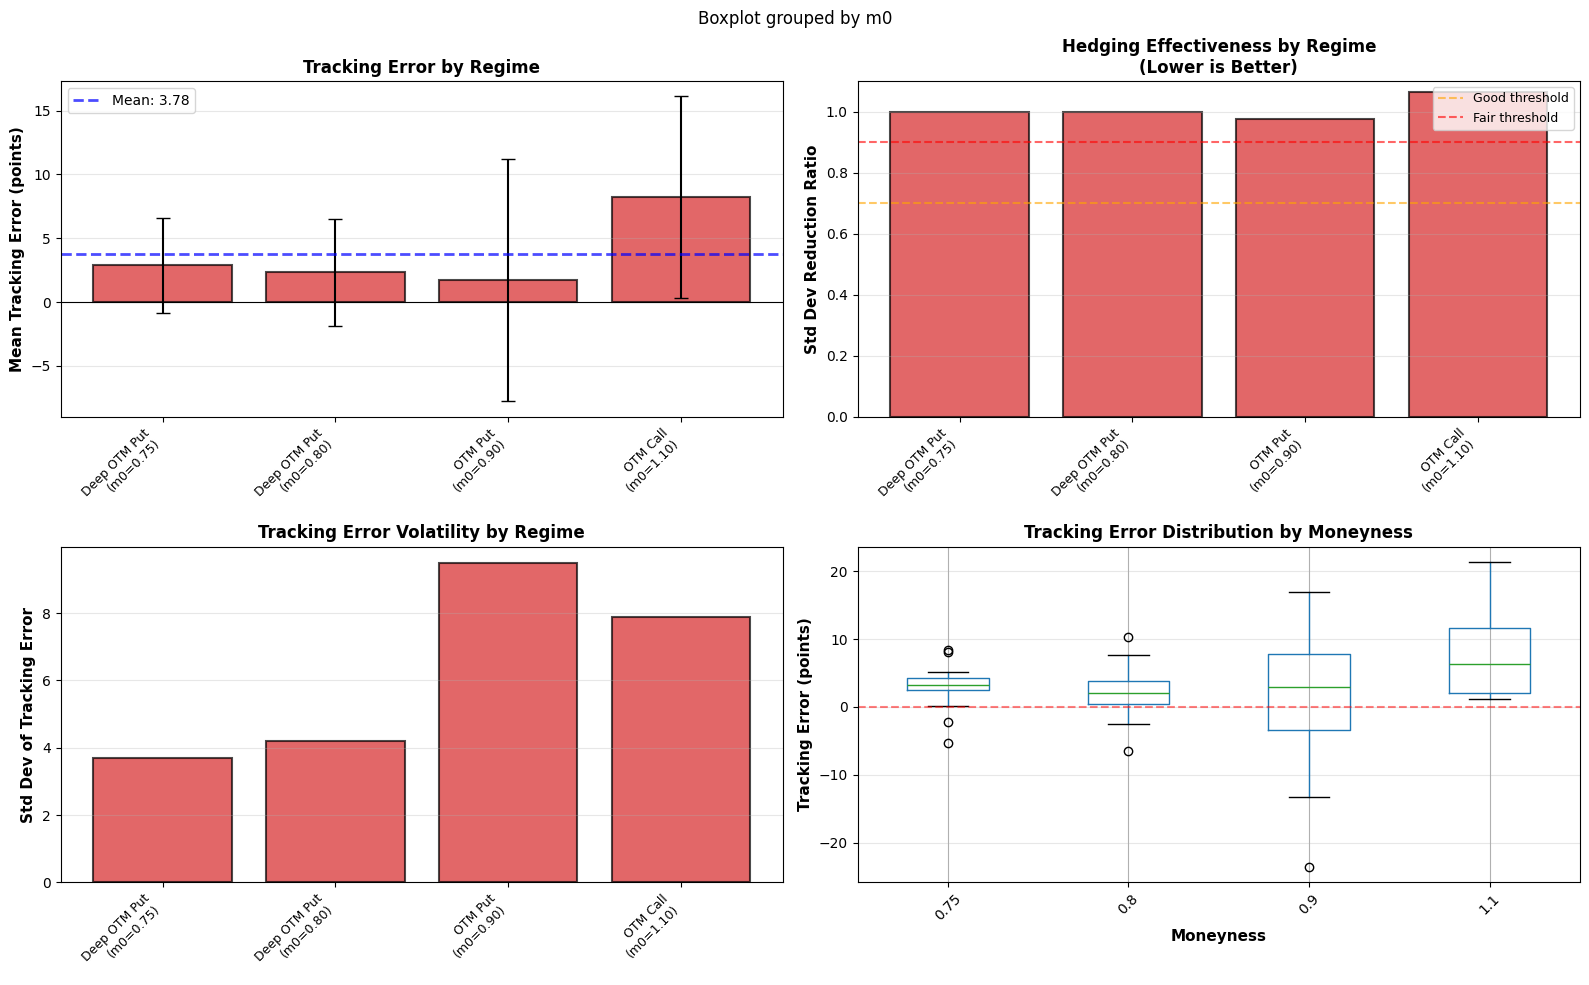


✓ Saved: regime_analysis_by_moneyness.png

KEY INTERPRETATIONS

1. ATM Performance: No ATM data in backtest

2. OTM Put Performance:
   Deep OTM Put (m0=0.75): TE=2.870
   Deep OTM Put (m0=0.80): TE=2.313
   OTM Put (m0=0.90): TE=1.714

3. OTM Call Performance:
   OTM Call (m0=1.10): TE=8.213

4. Overall Hedging Effectiveness:
   Volatility reduction: 0.995
   ⚠️  WEAK


✓ Saved: regime_analysis_by_moneyness.csv

✓ REGIME ANALYSIS COMPLETE



In [34]:
# %%
# === SECTION 20: REGIME-BASED ANALYSIS (BY MONEYNESS) - SIMPLIFIED ===

print("\n" + "="*80)
print("REGIME-BASED ANALYSIS: VolGAN Performance by Moneyness")
print("="*80)

# Get actual m0 values from results
unique_m0 = sorted(results_volgan['m0'].unique())
print(f"\nAnalyzing {len(unique_m0)} moneyness levels: {unique_m0}\n")

# Build regime analysis directly from results
regime_analysis = []

for m0_val in unique_m0:
    # Filter for this m0
    mask = results_volgan['m0'] == m0_val
    m0_results = results_volgan[mask]
    
    if len(m0_results) == 0:
        continue
    
    # Determine regime type
    if m0_val < 0.90:
        regime_type = "Deep OTM Put"
    elif m0_val < 0.95:
        regime_type = "OTM Put"
    elif m0_val < 1.05:
        regime_type = "ATM"
    elif m0_val < 1.15:
        regime_type = "OTM Call"
    else:
        regime_type = "Deep OTM Call"
    
    # Extract metrics
    te = m0_results['tracking_error']
    pnl_h = m0_results['pnl_hedged']
    pnl_u = m0_results['pnl_unhedged']
    
    # Calculate effectiveness
    if pnl_u.std() > 0:
        hedge_ratio = pnl_h.std() / pnl_u.std()
    else:
        hedge_ratio = np.nan
    
    regime_analysis.append({
        'regime_type': regime_type,
        'm0': m0_val,
        'n_windows': len(m0_results),
        'te_mean': te.mean(),
        'te_median': te.median(),
        'te_std': te.std(),
        'te_min': te.min(),
        'te_max': te.max(),
        'pnl_hedged_mean': pnl_h.mean(),
        'pnl_hedged_std': pnl_h.std(),
        'pnl_unhedged_mean': pnl_u.mean(),
        'pnl_unhedged_std': pnl_u.std(),
        'hedge_ratio': hedge_ratio,
    })

regime_df = pd.DataFrame(regime_analysis)

# %%
# === SECTION 20B: PRINT DETAILED ANALYSIS ===

print("-"*80)
print("DETAILED REGIME ANALYSIS")
print("-"*80 + "\n")

for _, row in regime_df.iterrows():
    print(f"\nREGIME: {row['regime_type'].upper()} (m0={row['m0']:.2f})")
    print(f"Sample size: {row['n_windows']} windows")
    print(f"\n  Tracking Error:")
    print(f"    Mean:       {row['te_mean']:>10.3f}")
    print(f"    Median:     {row['te_median']:>10.3f}")
    print(f"    Std Dev:    {row['te_std']:>10.3f}")
    print(f"    Range:      [{row['te_min']:>7.3f}, {row['te_max']:>7.3f}]")
    
    print(f"\n  PnL Analysis:")
    print(f"    Hedged PnL mean:    {row['pnl_hedged_mean']:>10.3f}")
    print(f"    Hedged PnL std:     {row['pnl_hedged_std']:>10.3f}")
    print(f"    Unhedged PnL mean:  {row['pnl_unhedged_mean']:>10.3f}")
    print(f"    Unhedged PnL std:   {row['pnl_unhedged_std']:>10.3f}")
    
    print(f"\n  Hedging Effectiveness:")
    if np.isnan(row['hedge_ratio']):
        print(f"    Ratio: N/A")
    else:
        ratio = row['hedge_ratio']
        if ratio < 0.5:
            status = "✓ EXCELLENT"
        elif ratio < 0.7:
            status = "✓ GOOD"
        elif ratio < 0.9:
            status = "✓ ACCEPTABLE"
        else:
            status = "⚠️  WEAK"
        print(f"    Ratio: {ratio:.3f} {status}")

# %%
# === SECTION 20C: SUMMARY TABLE ===

print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80 + "\n")

summary_table = regime_df[[
    'regime_type', 'm0', 'n_windows',
    'te_mean', 'te_std', 'hedge_ratio'
]].copy()

summary_table.columns = [
    'Regime', 'm0', 'Windows',
    'TE Mean', 'TE Std', 'Hedge Ratio'
]

print(summary_table.to_string(index=False))

# %%
# === SECTION 20D: VISUALIZATIONS ===

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Tracking Error by m0
ax = axes[0, 0]
colors = []
for regime_type in regime_df['regime_type']:
    if 'ATM' in regime_type:
        colors.append('#2ca02c')  # Green
    else:
        colors.append('#d62728')  # Red

ax.bar(range(len(regime_df)), regime_df['te_mean'], color=colors, alpha=0.7, 
       edgecolor='black', linewidth=1.5, yerr=regime_df['te_std'], capsize=5)
ax.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax.axhline(regime_df['te_mean'].mean(), color='blue', linestyle='--', 
          linewidth=2, alpha=0.7, label=f"Mean: {regime_df['te_mean'].mean():.2f}")
ax.set_xticks(range(len(regime_df)))
ax.set_xticklabels([f"{r}\n(m0={m:.2f})" for r, m in zip(regime_df['regime_type'], regime_df['m0'])], 
                   rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Mean Tracking Error (points)', fontsize=11, fontweight='bold')
ax.set_title('Tracking Error by Regime', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Plot 2: Hedging Ratio (Effectiveness)
ax = axes[0, 1]
colors = []
for ratio in regime_df['hedge_ratio']:
    if np.isnan(ratio):
        colors.append('#cccccc')  # Gray for NaN
    elif ratio < 0.7:
        colors.append('#2ca02c')  # Green - excellent
    elif ratio < 0.9:
        colors.append('#ff7f0e')  # Orange - good
    else:
        colors.append('#d62728')  # Red - weak

ax.bar(range(len(regime_df)), regime_df['hedge_ratio'], color=colors, alpha=0.7, 
       edgecolor='black', linewidth=1.5)
ax.axhline(0.7, color='orange', linestyle='--', alpha=0.6, linewidth=1.5, label='Good threshold')
ax.axhline(0.9, color='red', linestyle='--', alpha=0.6, linewidth=1.5, label='Fair threshold')
ax.set_xticks(range(len(regime_df)))
ax.set_xticklabels([f"{r}\n(m0={m:.2f})" for r, m in zip(regime_df['regime_type'], regime_df['m0'])], 
                   rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Std Dev Reduction Ratio', fontsize=11, fontweight='bold')
ax.set_title('Hedging Effectiveness by Regime\n(Lower is Better)', fontsize=12, fontweight='bold')
ax.set_ylim([0, 1.1])
ax.legend(fontsize=9)
ax.grid(axis='y', alpha=0.3)

# Plot 3: Tracking Error Volatility
ax = axes[1, 0]
colors = []
for regime_type in regime_df['regime_type']:
    if 'ATM' in regime_type:
        colors.append('#2ca02c')
    else:
        colors.append('#d62728')

ax.bar(range(len(regime_df)), regime_df['te_std'], color=colors, alpha=0.7, 
       edgecolor='black', linewidth=1.5)
ax.set_xticks(range(len(regime_df)))
ax.set_xticklabels([f"{r}\n(m0={m:.2f})" for r, m in zip(regime_df['regime_type'], regime_df['m0'])], 
                   rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Std Dev of Tracking Error', fontsize=11, fontweight='bold')
ax.set_title('Tracking Error Volatility by Regime', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Plot 4: Box plot of tracking error by m0
ax = axes[1, 1]
m0_labels = [f"m0={m:.2f}" for m in unique_m0]
results_volgan.boxplot(column='tracking_error', by='m0', ax=ax)
ax.set_xlabel('Moneyness', fontsize=11, fontweight='bold')
ax.set_ylabel('Tracking Error (points)', fontsize=11, fontweight='bold')
ax.set_title('Tracking Error Distribution by Moneyness', fontsize=12, fontweight='bold')
ax.axhline(0, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
ax.grid(axis='y', alpha=0.3)
plt.sca(ax)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('regime_analysis_by_moneyness.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved: regime_analysis_by_moneyness.png")

# %%
# === SECTION 20E: INTERPRETATION ===

print("\n" + "="*80)
print("KEY INTERPRETATIONS")
print("="*80 + "\n")

# Check for ATM
atm_rows = regime_df[regime_df['regime_type'].str.contains('ATM', na=False)]
if len(atm_rows) > 0:
    te_mean = atm_rows['te_mean'].iloc[0]
    print(f"1. ATM Performance:")
    print(f"   Tracking error: {te_mean:.3f}")
    if abs(te_mean) < 10:
        print(f"   ✓ GOOD: Model captures ATM structure well\n")
    else:
        print(f"   ⚠️  Model struggles with ATM\n")
else:
    print("1. ATM Performance: No ATM data in backtest\n")

# Check puts
put_rows = regime_df[regime_df['regime_type'].str.contains('Put', na=False)]
if len(put_rows) > 0:
    print(f"2. OTM Put Performance:")
    for _, row in put_rows.iterrows():
        print(f"   {row['regime_type']} (m0={row['m0']:.2f}): TE={row['te_mean']:.3f}")
    print()
else:
    print("2. OTM Put Performance: No put data in backtest\n")

# Check calls
call_rows = regime_df[regime_df['regime_type'].str.contains('Call', na=False)]
if len(call_rows) > 0:
    print(f"3. OTM Call Performance:")
    for _, row in call_rows.iterrows():
        print(f"   {row['regime_type']} (m0={row['m0']:.2f}): TE={row['te_mean']:.3f}")
    print()
else:
    print("3. OTM Call Performance: No call data in backtest\n")

# Overall
overall_hedge = results_volgan['pnl_hedged'].std() / results_volgan['pnl_unhedged'].std()
print(f"4. Overall Hedging Effectiveness:")
print(f"   Volatility reduction: {overall_hedge:.3f}")
if overall_hedge < 0.5:
    print(f"   ✓ EXCELLENT")
elif overall_hedge < 0.7:
    print(f"   ✓ GOOD")
elif overall_hedge < 0.9:
    print(f"   ✓ ACCEPTABLE")
else:
    print(f"   ⚠️  WEAK\n")

# %%
# === SECTION 20F: SAVE RESULTS ===

regime_df.to_csv('regime_analysis_by_moneyness.csv', index=False)
print("\n✓ Saved: regime_analysis_by_moneyness.csv")

print("\n" + "="*80)
print("✓ REGIME ANALYSIS COMPLETE")
print("="*80 + "\n")


In [27]:
# === SECTION 19: Save Results ===

results_volgan.to_csv('results_volgan_final.csv', index=False)
print("Results saved to: results_volgan_final.csv")

Results saved to: results_volgan_final.csv
